This notebook allows to generate some of the figures from the article [Bouttier, Duttagupta, Denève, Jardri, Schizophrenia Research 2021]

In this work, we consider the dynamics of Belief Propagation (BP)/ and compare it to the dynamics of Circular Inference (CI) - the input signal to the network varies with time, i.e., BP/CI isn't given the time to converge for every set of inputs: it does inference in real time with changing sensory inputs. 

In this file, we compare the levels of neural activation of nodes (brain regions) between BP and CI, which is called overactivation. We show that overactivations are positive when averaged on many sensory inputs (i.e., nodes are overall more activated under CI compared to BP). By looking at the influence of the node type, we show that network hubs are more overactivated than nodes with low connectivity.

We model here resting-state / spontaneous activity: noise is provided to the network

In [1]:
#magic trick which allows the reloading of modules which have changed since their initial loading 
#--> no need to restart the kernel
%load_ext autoreload
%autoreload 2

# Fig 2C (belief as function of time in a simulation)

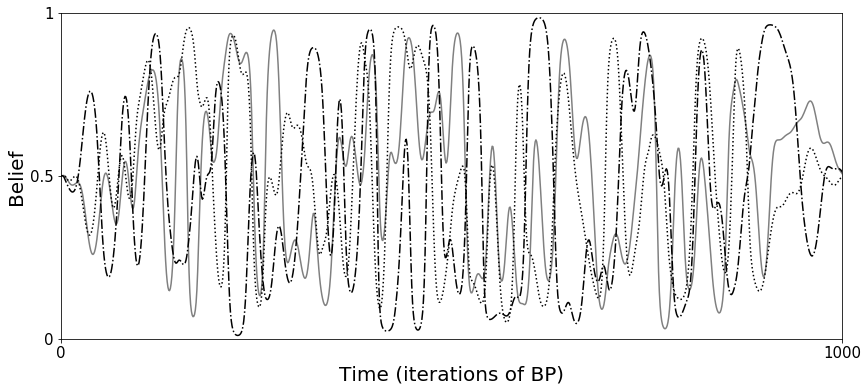

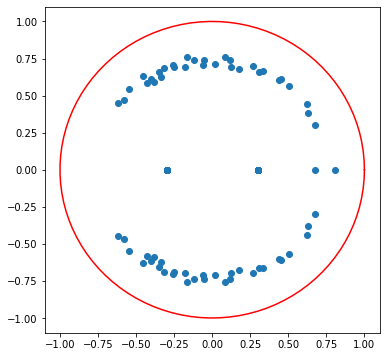

In [5]:
#Fig 2C (belief as function of time in a simulation)

from simulate import *
import pandas as pd
from utils_save_fig import save_fig
%matplotlib inline 

def sig(x):
    return 1 / (1+np.exp(-np.array(x)))



savefigs = True

#Arguments for the simulation
type_graph = 'modular_SW'
alpha_c, alpha_d = 1, 1
binarize_realistic_connectome = True
type_M_ext = 'gaussian_process_by_periods_not_all_nodes' #'gaussian_process_by_periods' #'poisson_process', 'gaussian_process' #'white_noise'
keep_history = True
begin = 0
method_weighting = 'bimodal_w'
remove_cerebellum_and_vermis = True
remove_ofc = True
T_period = 1000


res = Simulate(type_graph=type_graph, type_M_ext=type_M_ext,
               alpha_c=alpha_c, alpha_d=alpha_d,
               run_also_BP=False,
               begin=begin, keep_history=keep_history,
               n_periods=1,
               variance_Mext=100, T_period=T_period, #mean_Mext='random_2', #1, #variance_Mext=0.1
#                n_stimulated_nodes=1, 
               stimulated_nodes="all", #stimulated_nodes="visual" #stimulates specific nodes (give list or "visual" or "auditory" (in these 2 last cases the stimulated regions are the associated primary cortices))
#                stimulated_nodes="parahipp_L", #"language", #"visual", #stimulates specific nodes (give list or "visual" or "auditory" (in these 2 last cases the stimulated regions are the associated primary cortices))
               remove_cerebellum_and_vermis=remove_cerebellum_and_vermis, remove_ofc=remove_ofc,
#                binarize_realistic_connectome=binarize_realistic_connectome,
               method_weighting=method_weighting, w_uniform=None,
#                print_advancement=True
              )


plt.figure(figsize=(14,6))
list_linestyles = ['-', ':', '-.'] #'--'
list_colors = ['grey', 'black', 'black']
# for node, B in res.B_history_CI.items():
#     if node in [0,1,2]:
#         plt.plot(sig(B))
#         plt.plot(sig(B), color='black', linestyle=list_linestyles[node])
#         plt.plot(sig(B), color=list_colors[node], linestyle=list_linestyles[node])
for i_node, node in enumerate([0,9,30]):
    B = res.B_history_CI[node]
    plt.plot(sig(B), color=list_colors[i_node], linestyle=list_linestyles[i_node])
plt.xlim(0,1000)
plt.ylim(0,1)
plt.yticks([0, 0.5, 1], [0, 0.5, 1], size=15)
plt.xticks([0, 1000], size=15) #plt.xticks([0, 500, 1000], size=15)
plt.xlabel('Time (iterations of BP)', size=20)
plt.ylabel('Belief', size=20)
# plt.annotate(s='test', xy=(1,1), xytext=(250,-0.05), arrowprops=dict(arrowstyle='<->'), va='center')
# plt.annotate(s='test', xy=(1,1), xytext=(750,-0.05), arrowprops=dict(arrowstyle='<->'), va='center')
# plt.annotate('DOUBLE', xy=(200,0.5), xytext=(0.01,0.5),
#              arrowprops={'arrowstyle': '<->'}, va='center')
# save_fig('Fig2C', type_graph)
plt.show()

plot_eigenvalues_from_graph(res.graph_G, alpha=alpha_c, order='exact')

# Running one simulation (checking that it has no bistability nore frustration) and plot many things

In [1]:
#Simulate BP and CI for a given graph (or load previously simulated data)

from simulate import *
from compute_effects_CI_vs_BP import *
from utils_stability_analysis import *
from utils_find_hubs import *
from utils_save_fig import save_fig
from utils_dict import *
from utils_plot_dict import *
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

def sig(x):
    return 1 / (1+np.exp(-np.array(x)))

def load_random_simulation(type_graph, remove_cerebellum_and_vermis, remove_ofc, type_M_ext,
                           path_dir_save
                          ):
    """ Loads a random simulation """
    suffix_folder = get_suffix_to_folder(type_graph, remove_cerebellum_and_vermis, remove_ofc)
#     print(os.listdir(path_dir_save))
    check_folder_exists(path_dir_save) #create folder if it does not exist
    if (type_graph + suffix_folder in os.listdir(path_dir_save)) == False:
        print("There are no simulations to load - generate data with the following command: 'python compute_effects_CI_vs_BP.py {}'. Alternative (not advised): change load_data to False".format(type_graph))
        sys.exit()
    list_files = os.listdir(path_dir_save + type_graph + suffix_folder + '/')
    list_files = [el for el in list_files if '.pkl' in el]
    list_files = [el for el in list_files if type_M_ext in el] #select only files with the same generation process for M_ext
    random_file = np.random.choice(list_files) #picking a random simulation
    with open(path_dir_save + type_graph + suffix_folder + '/' + random_file, 'rb') as f:
        res = dill.load(f)
    assert type(res) == Simulate
    return res


#Arguments for the simulation
type_graph = 'realistic_connectome_AAL2' #'modular_SW' #'realistic_connectome_HCP'
alpha_c, alpha_d = (0.8, 0.8) #needs to be different from (1, 1), otherwise overactivation = 0
type_M_ext = 'gaussian_process_by_periods_not_all_nodes' #'gaussian_process_by_periods' #'poisson_process', 'gaussian_process' #'white_noise'
begin = 0 #50
remove_cerebellum_and_vermis = True
remove_ofc = True

load_data = True #True #if True, load simulate data. if False, launch a new simulation.
if not load_data:
    print("Simulating new data (not advised because long - run instead compute_effects.py {})".format(type_graph))
else:
    print("Loading previously simulated data")

    
cpt = 0
while True:
    print("Attempt number {}".format(cpt + 1))
#     if cpt == 1:
#         break #removes the possibility of a second attempt
    cpt += 1
    if not load_data:
        
        #provide additionnal arguments
        keep_history = True
        T_period = 1000 #1000 for small graphs, 1000 for big graphs
        binarize_realistic_connectome = True
        method_weighting = 'bimodal_w'
        
        #Simulate
        res = Simulate(type_graph=type_graph, 
                       remove_cerebellum_and_vermis=remove_cerebellum_and_vermis, remove_ofc=remove_ofc,
                       binarize_realistic_connectome=binarize_realistic_connectome,
                       method_weighting=method_weighting, w_uniform=None,
                       
                       type_M_ext=type_M_ext,
                       n_periods=1,
                       variance_Mext=30, T_period=T_period,# mean_Mext='random_2', #1, #variance_Mext=0.1
#                        n_stimulated_nodes=1, 
                       stimulated_nodes="all", #stimulated_nodes="visual" #stimulates specific nodes (give list or "visual" or "auditory" (in these 2 last cases the stimulated regions are the associated primary cortices))
#                        stimulated_nodes="parahipp_L", #"language", #"visual", #stimulates specific nodes (give list or "visual" or "auditory" (in these 2 last cases the stimulated regions are the associated primary cortices))
                       
                       alpha_c=alpha_c, alpha_d=alpha_d,
                       run_also_BP=True,
                       begin=begin, keep_history=keep_history,
                       
                       print_advancement=True
                      )
    else:
        #load a random simulation
        res = load_random_simulation(type_graph, remove_cerebellum_and_vermis, remove_ofc, type_M_ext,
                                     path_dir_save
                                    )

    plot_pbs = True
    if load_data and res.skipping == True:
        continue
    if hasattr(res, 'B_history_BP') and res.check_frustration_BP(begin=begin, plot=plot_pbs):
        print("Frustration detected (alpha_c = {}, alpha_d = {})".format(1, 1))
        plot_eigenvalues_from_graph(res.graph_G, alpha=1, order='exact')
        continue
    if res.check_frustration_CI(begin=begin, plot=plot_pbs):
        print("Frustration detected (alpha_c = {}, alpha_d = {})".format(alpha_c, alpha_d))
        plot_eigenvalues_from_graph(res.graph_G, alpha=alpha_c, order='exact') #hyp: alpha_c = alpha_d
        continue
    if hasattr(res, 'B_history_BP') and res.check_bistability_BP(plot=plot_pbs):
        print("trying another graph (cpt = {})".format(cpt))
        plot_eigenvalues_from_graph(res.graph_G, alpha=1, order='exact')
        continue
    if res.check_bistability_CI(plot=plot_pbs):
        print("trying another graph (cpt = {})".format(cpt))
        plot_eigenvalues_from_graph(res.graph_G, alpha=alpha_c, order='exact') #hyp: alpha_c = alpha_d
        continue
    if load_data:
        res.B_history_BP = res.B_history_CI_all[1,1]
        res.B_history_CI = res.B_history_CI_all[alpha_c, alpha_d]
    print("Got a simulation without bistability nore frustration")
    break #goes out the while loop


/home/vincent/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Simulating new data
Attempt number 1
...removed the 1 unconnected nodes (['Rolandic_Oper_R'])
Finished generating and weighting the graph
Finished generating the external messages
Finished running CI
Finished looking for frustration/bistability for CI
Finished running BP
Finished looking for frustration/bistability for BP
Got a simulation without bistability nore frustration


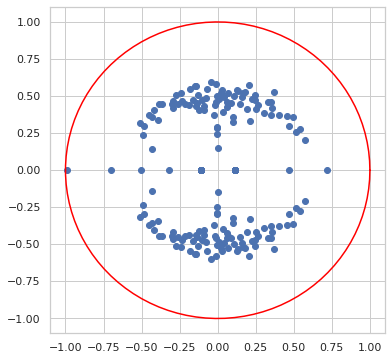

In [2]:
# plot_eigenvalues_from_graph(res.graph_G, order='0')
plot_eigenvalues_from_graph(res.graph_G, alpha=alpha_c, order='exact') #order='1' #order='inf' #(hyp: alpha_c = alpha_d)
# plot_eigenvalues_from_graph(res.graph_G, alpha=1, order='exact')

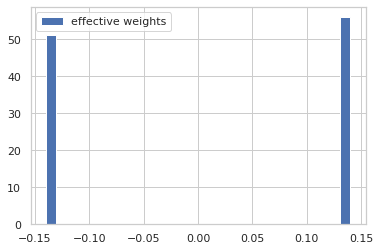

In [3]:
#Plot the histogram of the graph's weights

plt.hist(2*np.array([el[2]['weight'] for el in res.graph_G.edges(data=True)])-1, bins=30, label="effective weights", density=True) #2*weights - 1 (effective weight). According to Adrian, the variance should be below or equal to 1 in order not to have chaos
# plt.hist(np.random.normal(size=1000, scale=1/np.sqrt(120)), bins=20, alpha=0.5, color='red', label="normal distrib", density=True) #normal distribution
plt.legend()
plt.show()

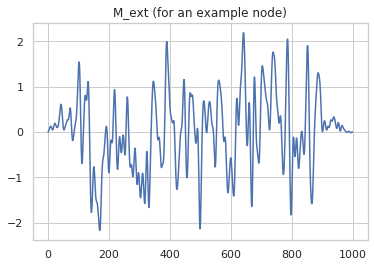

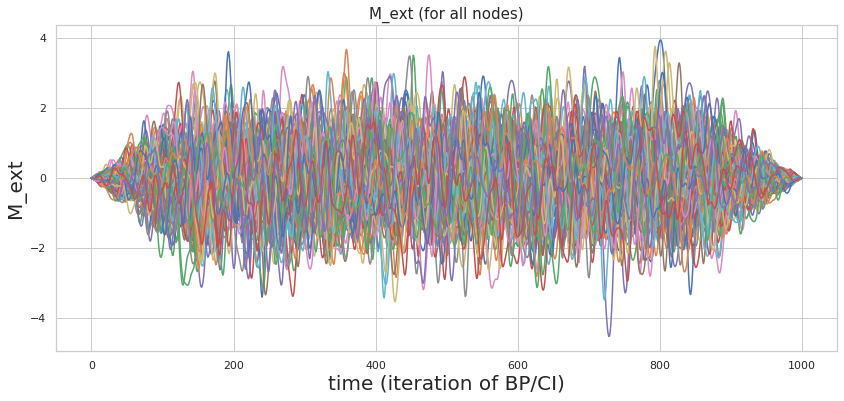

In [4]:
#Plot M_ext

nodes_being_stimulated = [node for node,M_ext_node in res.M_ext.items() if np.sum(M_ext_node) != 0]
if len(nodes_being_stimulated) != len(res.graph_G):
    print("{} nodes are stimulated: {}".format(len(nodes_being_stimulated), nodes_being_stimulated))

show_one_node = True #show M_ext for a single node
plot_M_ext(res.M_ext, show_one_node=show_one_node)

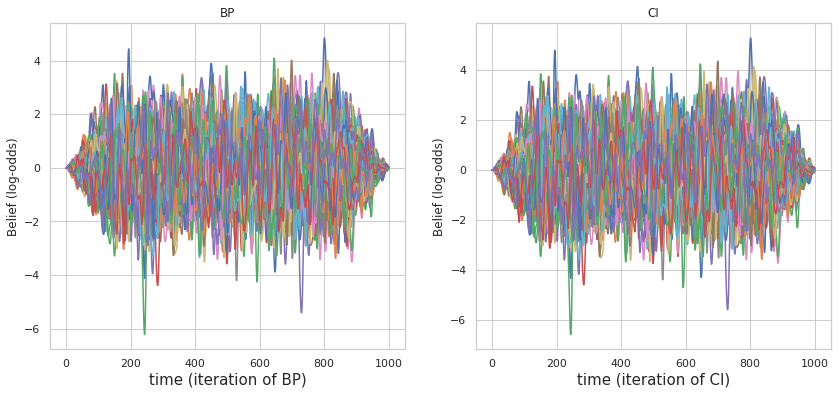

In [5]:
#Plot the dynamics of the beliefs (for BP and for CI) for all nodes of the network
plot_B_history_BP_B_history_CI(res.B_history_BP, res.B_history_CI)

node selected: Temporal_Mid_L


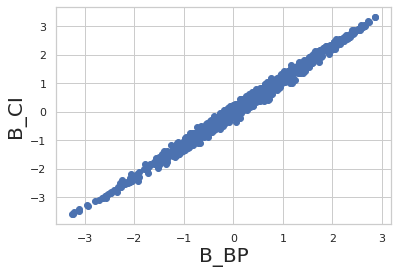

/home/vincent/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vincent/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


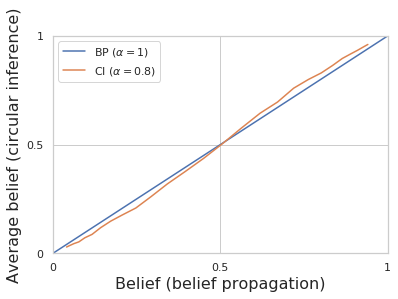

In [6]:
#Fig 3A (p_CI vs p_BP)

alpha_CI = (alpha_c, alpha_d)

node_selected = list(sort_dict_by_value(dict(res.graph_G.degree())).keys())[0] #node with the highest degree
# node_selected = 14
print("node selected:", node_selected)

alpha_BP = (1,1)
# plt.plot([0,1], [0,1], label=r'BP ($\alpha = {}$)'.format(alpha_BP[0]))#, color=colors_alphas[alpha_BP])  #identity line (= BP) #case alpha_c = alpha_d
x = res.B_history_BP[node_selected]
y = res.B_history_CI[node_selected]
plt.xlabel('B_BP', size=20)
plt.ylabel('B_CI', size=20)
plt.scatter(x, y)
plt.show()


plt.plot([0,1], [0,1], label=r'BP ($\alpha = {}$)'.format(alpha_BP[0]))#, color=colors_alphas[alpha_BP])  #identity line (= BP) #case alpha_c = alpha_d

#show the average by bins
x_bins = []
y_bins = []
bins_x = np.linspace(np.min(x)-0.01, np.max(y)+0.01, 30)
for i in range(len(bins_x)-1):
    mean_y_bin = np.mean(y[(x>bins_x[i]) * (x<=bins_x[i+1])])
    mean_x_bin = np.mean([bins_x[i], bins_x[i+1]])
    x_bins.append([mean_x_bin])
    y_bins.append([mean_y_bin])
#     plt.scatter(sig(x_bins), sig(y_bins), label='alpha = {}'.format(alpha_CI))
#     plt.plot(sig(x_bins), sig(y_bins), label=r'CI ($\alpha = {}$)'.format(alpha_CI), color=colors_alphas[alpha_CI])
plt.plot(sig(x_bins), sig(y_bins), label=r'CI ($\alpha = {}$)'.format(alpha_CI[0]))#, color=colors_alphas[alpha_CI]) #case alpha_c = alpha_d
plt.xlabel('Belief (belief propagation)', size=16)
plt.ylabel('Average belief (circular inference)', size=16) #plt.ylabel('p_CI (averaged over bins of p_BP)')
plt.xticks([0,0.5,1], [0,0.5,1])
plt.yticks([0,0.5,1], [0,0.5,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
# save_fig('Fig3A', type_graph)
plt.show()

In [7]:
#Compute the activations and overactivations

k = 0.05 #np.inf
method='leaky_belief'


#1. Compute the activations

#BP
activations_history_BP = res.compute_activations_history_BP(method=method, k=k)
total_activation_BP = res.compute_total_activation_BP(method=method, k=k, begin=begin)
confidence_history_BP = res.compute_confidence_history_BP(method=method)
total_confidence_BP = res.compute_total_confidence_BP(method=method, begin=begin)

#CI 
activations_history_CI = res.compute_activations_history_CI(method=method, k=k)
total_activation_CI = res.compute_total_activation_CI(method=method, k=k, begin=begin)
confidence_history_CI = res.compute_confidence_history_CI(method=method)
total_confidence_CI = res.compute_total_confidence_CI(method=method, begin=begin)


#2. Compute the overactivations

which = 'percent' #'diff'
d_overactivation = res.compute_overactivation(method=method, k=k, begin=begin, which=which)
d_overconfidence = res.compute_overconfidence(method=method, begin=begin, which=which)

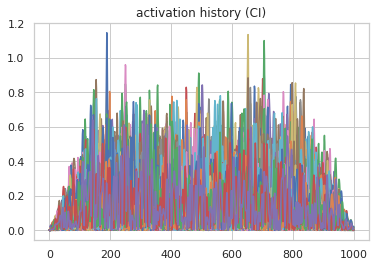

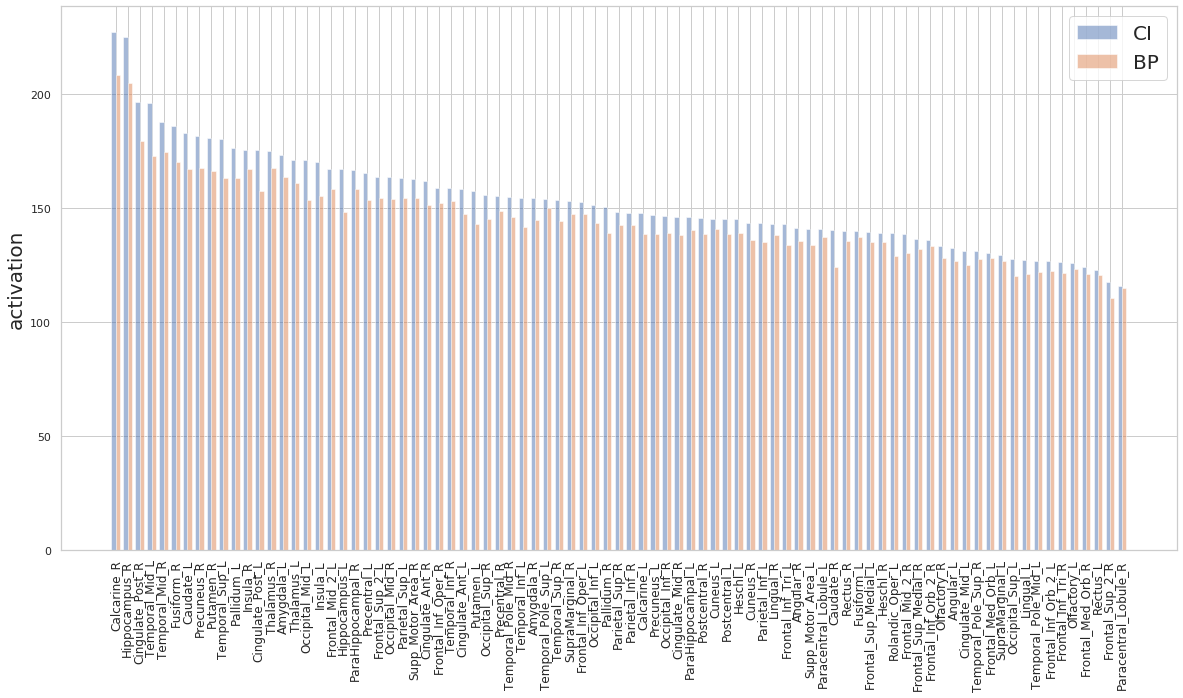

Same plot as above, where nodes colored in red are the nodes which receive sensory input (possibly all are colored in red):


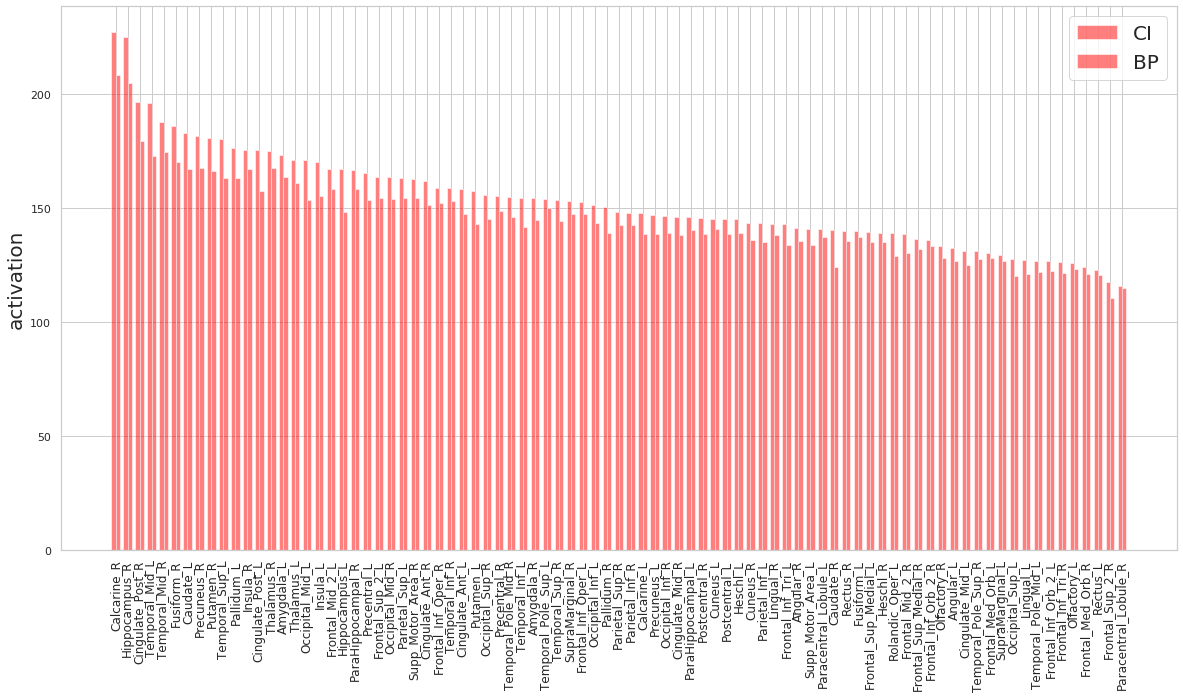

Nodes colored in red are the nodes which receive sensory input (possibly all are colored in red):


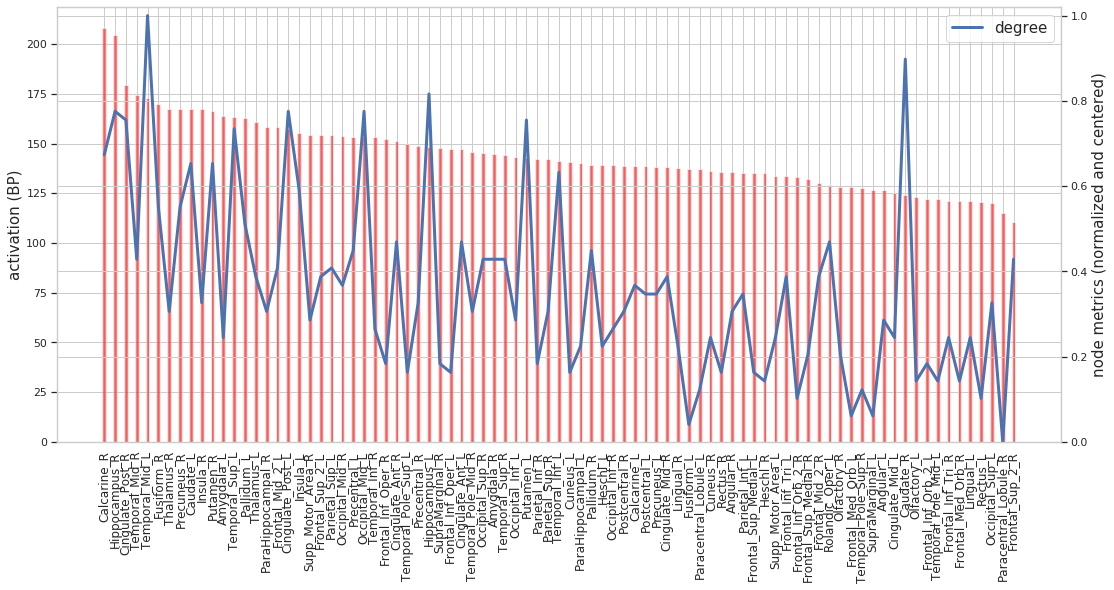

Nodes colored in red are the nodes which receive sensory input (possibly all are colored in red):


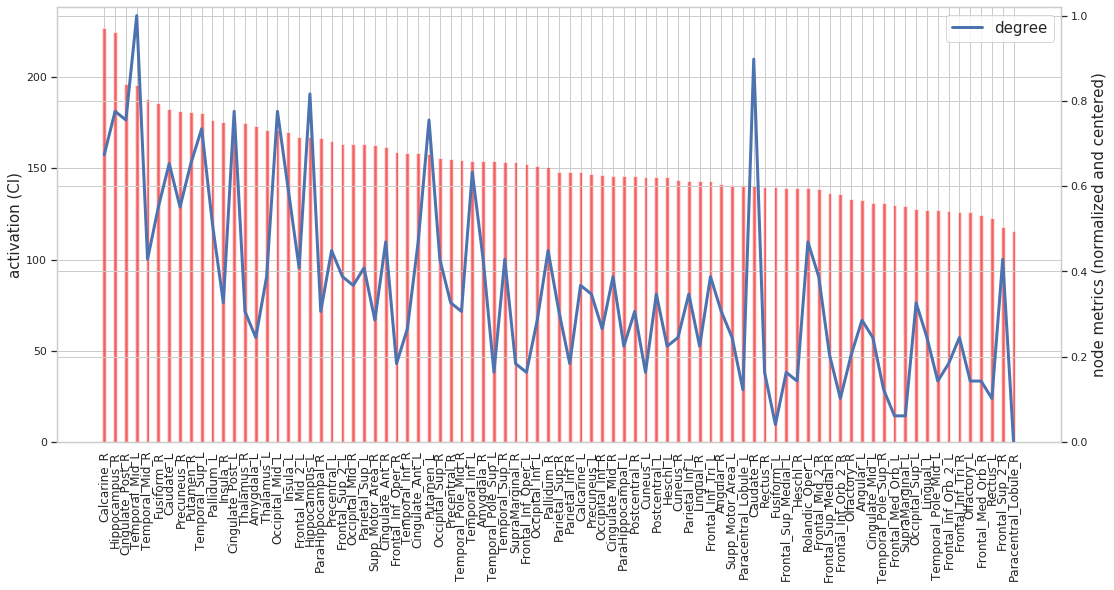

Nodes colored in red are the nodes which receive sensory input (possibly all are colored in red):


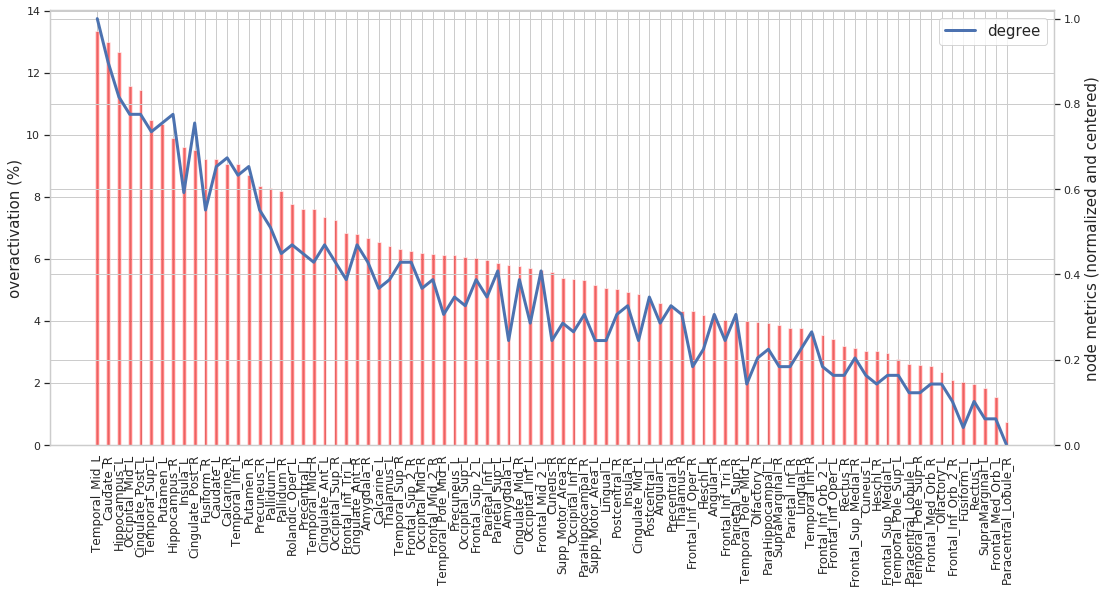

In [8]:
#Plot the activations (BP and CI) and overactivations (CI vs BP)


from utils_dict import *
from utils_plot_dict import *
from utils_graph_measures import *


def get_stimulated_nodes(stimulated_nodes):
    
    assert isinstance(stimulated_nodes, str)
    
    list_i_node, list_names = read_AAL2_file(type_graph.replace('realistic_connectome_', ''))
    mapping_nodes = dict(zip(list_i_node,list_names))
    primary_cortices = {"auditory": [83,84] if 'AAL2' in type_graph else [29,30], #primary auditory cortex (83,84) #but 84 is unconnected to the rest of the graph for AAL2) --> no, in fact it's connected...
                        "visual": [49,50] if 'AAL2' in type_graph else [19,20], #primary visual cortex (49,50)
                        "language": [7,8,9,10,11,12,65,66,67,68,85,86] if 'AAL2' in type_graph else sys.exit(), #7-12 Broca, 65-68 aire de wernicke, 85-86 ?
                        "parahipp_L": [41,43] if 'AAL2' in type_graph else sys.exit()
                       }
#         associative_cortices = {"auditory": [85,86,87,88,89,90] if 'AAL2' in type_graph else [71,72],
#                                 "visual": [51,52,53,54,55,56,57,58,59,60] if 'AAL2' in type_graph else [35,36,37,38,27,28] #not sure for the associative_cortices of the visual in AAL-merged: check with Renaud
#                                }
    assert stimulated_nodes in primary_cortices.keys()
#         if stimulated_nodes in ["auditory","visual"]:
    stimulated_nodes = [mapping_nodes[el] for el in primary_cortices[stimulated_nodes]]
#         else:
#             stimulated_nodes = [mapping_nodes[el] for el in primary_cortices["visual"]] #primary auditory cortices
#         print("stimulated_nodes", stimulated_nodes)
    return stimulated_nodes


plot_activations_history_CI(activations_history_CI)


#print the stimulated nodes
nodes_being_stimulated = [node for node,M_ext_node in res.M_ext.items() if np.sum(M_ext_node) != 0] #ok for no external fields
# nodes_being_stimulated = get_stimulated_nodes("parahipp_L") #"language") #) #for external fields (to be improved to be automatic in all cases)
if len(nodes_being_stimulated) != len(res.graph_G):
    print("{} nodes are stimulated: {}".format(len(nodes_being_stimulated), nodes_being_stimulated))


# plot_dict_ordered(total_activation_BP, ylabel="activation", colored_keys=nodes_being_stimulated)
# plot_dict_ordered(total_activation_CI, ylabel="activation", colored_keys=nodes_being_stimulated)
plot_2_dicts_ordered({"CI": total_activation_CI, "BP": total_activation_BP}, ylabel="activation")
print("Same plot as above, where nodes colored in red are the nodes which receive sensory input (possibly all are colored in red):")
plot_2_dicts_ordered({"CI": total_activation_CI, "BP": total_activation_BP}, ylabel="activation", colored_keys=nodes_being_stimulated)


#Activation in BP or CI vs degree  
# plot_dict_ordered(total_activation_BP, ylabel="activation", colored_keys=nodes_being_stimulated)
# plot_dict_ordered(total_activation_CI, ylabel="activation", colored_keys=nodes_being_stimulated)
print("Nodes colored in red are the nodes which receive sensory input (possibly all are colored in red):")
plot_dict_ordered_with_additional_curve(total_activation_BP, res.graph_G, ylabel='activation (BP)', list_measures=["degree"], colored_keys=nodes_being_stimulated)#, savefig=False)
print("Nodes colored in red are the nodes which receive sensory input (possibly all are colored in red):")
plot_dict_ordered_with_additional_curve(total_activation_CI, res.graph_G, ylabel='activation (CI)', list_measures=["degree"], colored_keys=nodes_being_stimulated)#, savefig=False)
    

#Overactivation vs degree
# # plot_dict_ordered(d_overactivation, ylabel="overactivation (%)")
# plot_dict_ordered(d_overactivation, ylabel="overactivation (%)", colored_keys=nodes_being_stimulated)
# #plot the degree
# d_overactivation_sorted = sort_dict_by_value(d_overactivation)
# plot_measure("degree", res.graph_G, order_keys=d_overactivation_sorted)
#overactivation and graph measures on top of each other (=same as above but on the same plot)
print("Nodes colored in red are the nodes which receive sensory input (possibly all are colored in red):")
plot_dict_ordered_with_additional_curve(d_overactivation, res.graph_G, ylabel='overactivation (%)', list_measures=["degree"], colored_keys=nodes_being_stimulated)#, savefig=False)

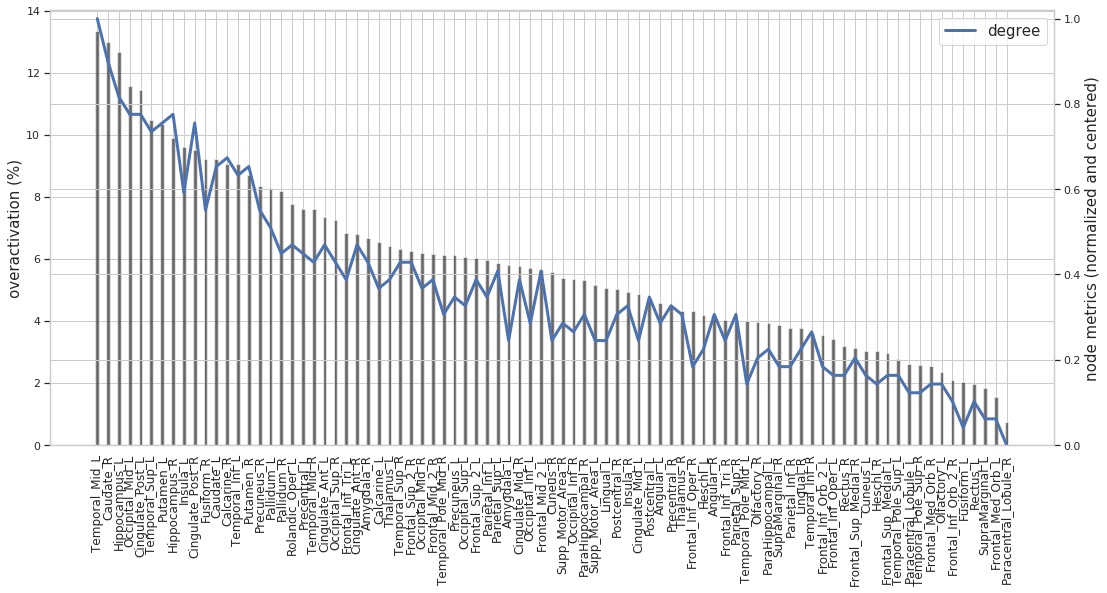

In [9]:
#Fig S6
plot_dict_ordered_with_additional_curve(d_overactivation, res.graph_G, ylabel='overactivation (%)', list_measures=["degree"]) #not saving the fig
# plot_dict_ordered_with_additional_curve(d_overactivation, res.graph_G, ylabel='overactivation (%)', list_measures=["degree"], savefig="FigS6") #saving the fig

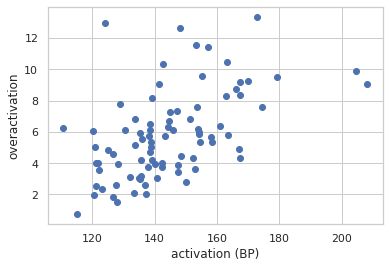

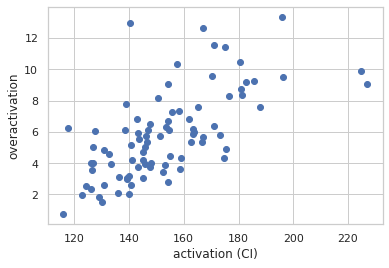

In [10]:
#Getting an intuition of the reasons why some nodes are more overactivated than others

#correlation between activation_BP and overactivation
x = list(total_activation_BP.values())
y = list({key:d_overactivation[key] for key in total_activation_BP.keys()}.values())
plt.scatter(x,y)
plt.xlabel("activation (BP)")
plt.ylabel("overactivation")
plt.show()

#correlation between activation_CI and overactivation
x = list(total_activation_CI.values())
y = list({key:d_overactivation[key] for key in total_activation_CI.keys()}.values())
plt.scatter(x,y)
plt.xlabel("activation (CI)")
plt.ylabel("overactivation")
plt.show()

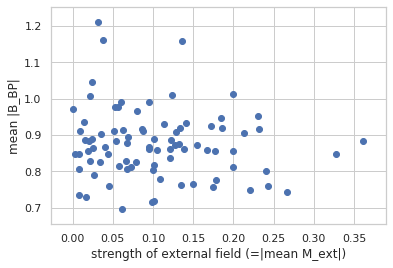

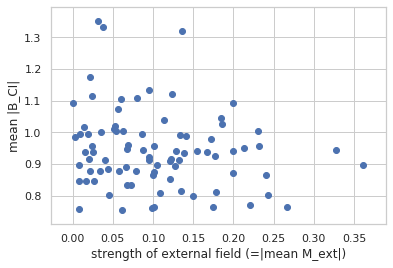

In [11]:
for which, B_history in {"BP": res.B_history_BP, "CI": res.B_history_CI}.items():
#     d_mean_B = {key:np.mean(val[100:-100]) for key,val in B_history.items()}
#     d_mean_Mext = {key:np.mean(val[100:-100]) for key,val in res.M_ext.items()}
#     x = list(d_mean_Mext.values())
#     y = list({key:d_mean_B[key] for key in d_mean_Mext.keys()}.values())
#     plt.scatter(x,y)
#     plt.xlabel("mean M_ext")
#     plt.ylabel("mean B_{}".format(which))
#     plt.show() #we see a correlation = normal
    
    d_mean_abs_B = {key:np.mean(np.abs(val[100:-100])) for key,val in B_history.items()} #activation for k=np.inf
    d_mean_Mext = {key:np.abs(np.mean(val[100:-100])) for key,val in res.M_ext.items()} #strength of external field
#     d_mean_Mext = {key:np.mean(val[100:-100]) for key,val in res.M_ext.items()} #external field
#     d_mean_Mext = {key:np.mean(np.abs(val[100:-100])) for key,val in res.M_ext.items()} #strength of input
    x = list(d_mean_Mext.values())
    y = list({key:d_mean_abs_B[key] for key in d_mean_Mext.keys()}.values())
    plt.scatter(x,y)
    plt.xlabel("strength of external field (=|mean M_ext|)")
    plt.ylabel("mean |B_{}|".format(which))
    plt.show() #no correlation for no external fields (normal); correlation for external fields 
    #+ expected correlation between np.mean(|M_ext|) and np.mean(|B|) for BP and CI

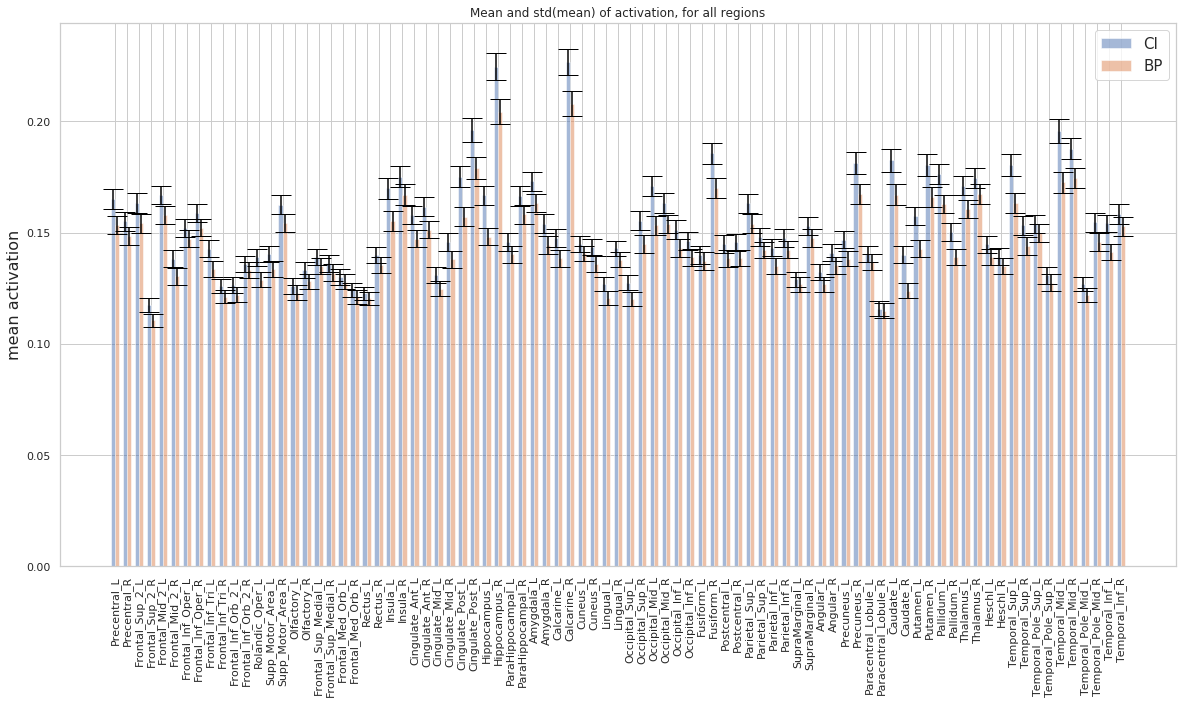

In [12]:
#plot the activation mean (+ error bar) for BP and CI, for all regions
#also defines total_activation_CI and total_activation_BP (among others)

total_activation_CI = {key: np.mean(val[begin:]) for key, val in activations_history_CI.items()} #SUM OR MEAN?
std_activation_CI = {key: np.std(val[begin:]) for key, val in activations_history_CI.items()}
std_total_activation_CI = {key: np.std(val[begin:]) / np.sqrt(len(val[begin:])) for key, val in activations_history_CI.items()} #std of the mean = std / sqrt(N)

total_activation_BP = {key: np.mean(val[begin:]) for key, val in activations_history_BP.items()}
std_activation_BP = {key: np.std(val[begin:]) for key, val in activations_history_BP.items()}
std_total_activation_BP = {key: np.std(val[begin:]) / np.sqrt(len(val[begin:])) for key, val in activations_history_BP.items()} #std of the mean = std / sqrt(N)

assert list(activations_history_CI.keys()) == list(activations_history_BP.keys())

# plt.plot(total_activation_CI)
# # plt.plot(total_activation_BP)
# plt.show()


#figure with both BP and CI, side by side (to see both)
plt.figure(figsize=(20,10))
width = 0.35
#CI
x_pos = np.array(range(len(total_activation_CI)))
plt.bar(x_pos - width/2, list(total_activation_CI.values()), width=width, yerr=list(std_total_activation_CI.values()), 
        align='center', alpha=0.5, ecolor='black', capsize=10, label='CI')
#BP
x_pos = np.array(range(len(total_activation_BP)))
plt.bar(x_pos + width/2, list(total_activation_BP.values()), width=width, yerr=list(std_total_activation_BP.values()), 
        align='center', alpha=0.5, ecolor='black', capsize=10, label='BP')
assert list(total_activation_CI.keys()) == list(total_activation_BP.keys())
plt.xticks(x_pos, labels=[node for node in total_activation_CI.keys()], rotation=90) ##dd ticks on the x-axis
plt.ylabel('mean activation', size=16)
plt.title('Mean and std(mean) of activation, for all regions')
plt.legend(prop={"size":15})
plt.show()

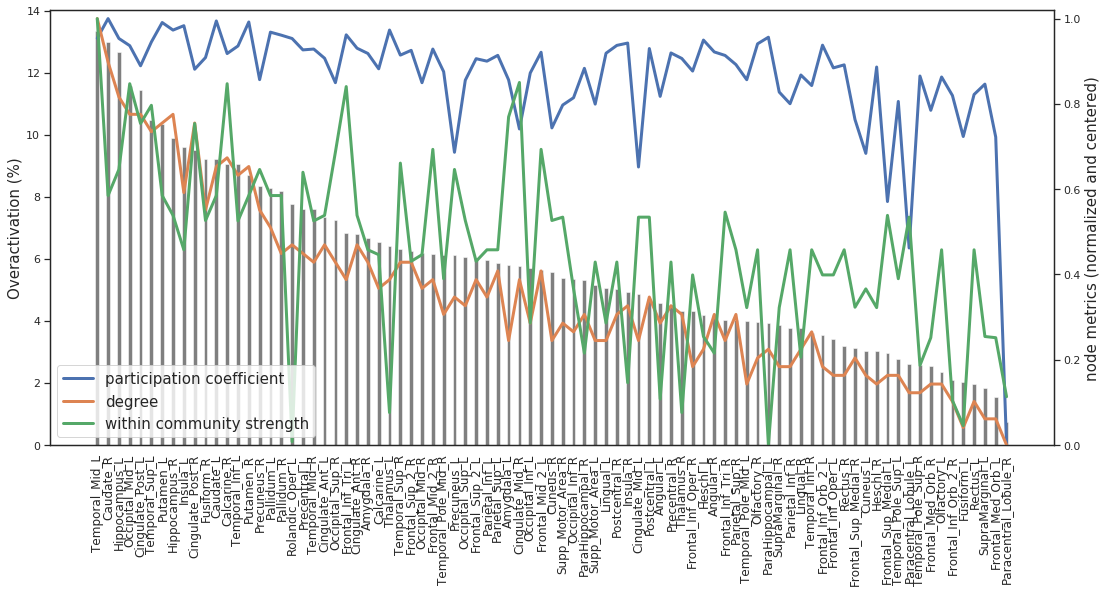

In [13]:
#figure with (CI - BP)/BP ---> fig S6A

from utils_graph_measures import *
sns.set(style='white')

# print("Sorted list of regions from the most overactivated (in %) to the least overactivated:\n", 
#       list(d_overactivation.keys()))

# plot_dict_ordered(d_overactivation, ylabel='Overactivation (%)')

#Activation under BP
# plot_dict_ordered(total_activation_BP, d_order=d_overactivation, 
#                   ylabel='mean activation', title_fig='Mean and std(mean) of activation, for all regions')


#Overactivation and graph measures on top of each other
list_measures = ["participation_coefficient_undirected", "degree", "within_community_strength_undirected"] #fun_measures.keys()
plot_dict_ordered_with_additional_curve(d_overactivation, res.graph_G, ylabel='Overactivation (%)', 
                                        list_measures=list_measures)#, savefig="FigS6A", type_graph=graph_G.type_graph)

The regions colored are the regions which are known to be highly overactivated during hallucinations (see the litterature)


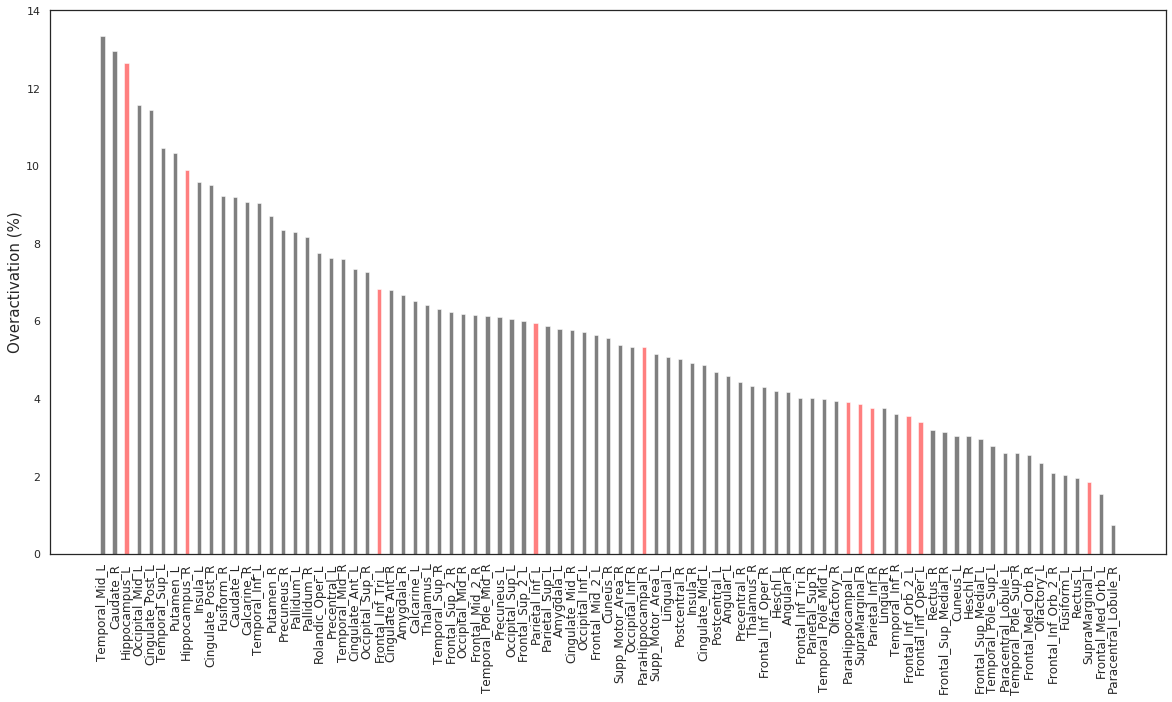

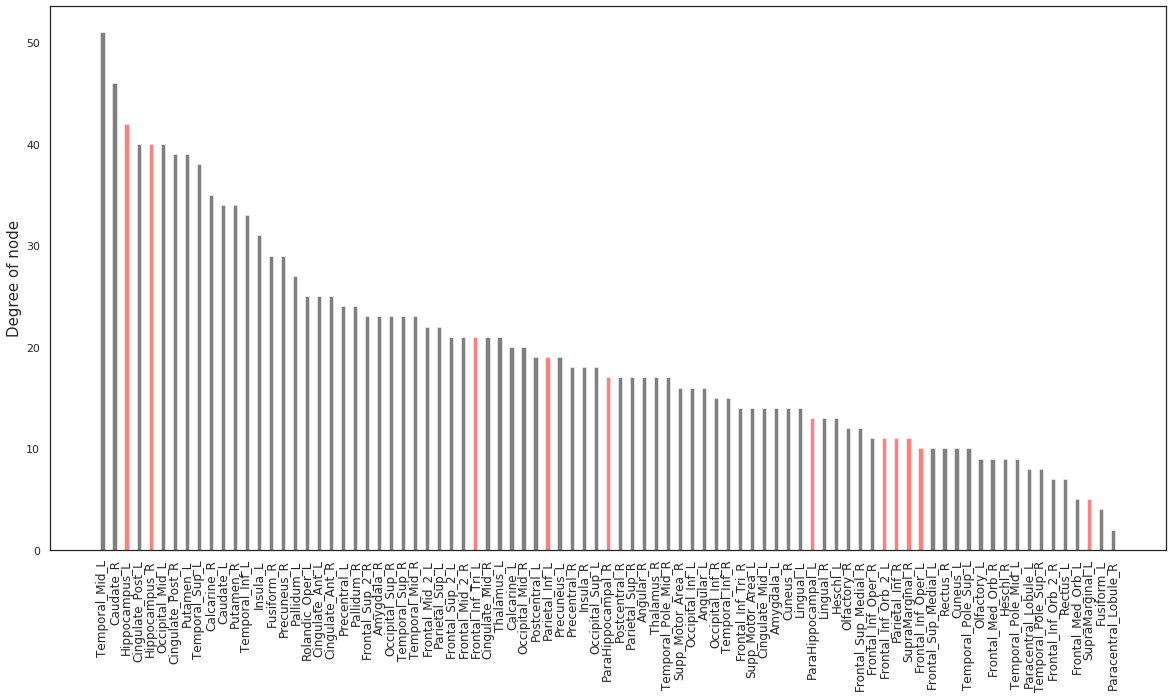

In [14]:
#Fig S6B

print("The regions colored are the regions which are known to be highly overactivated during hallucinations (see the litterature)")
regions_overactivated_hallucinations = [7,9,11,65,66,67,68,41,42,43,44] #from the litterature
list_i_node, list_names = read_AAL2_file(type_graph.replace('realistic_connectome_', ''))
mapping_nodes = dict(zip(list_i_node,list_names))
regions_overactivated_hallucinations = [mapping_nodes[el] for el in regions_overactivated_hallucinations]

plot_dict_ordered(d_overactivation, ylabel='Overactivation (%)', colored_keys=regions_overactivated_hallucinations)#, savefig="FigS6B", type_graph=graph_G.type_graph)

# print([res.graph_G.degree(node) for node in regions_overactivated_hallucinations])
plot_dict_ordered(dict(res.graph_G.degree()), ylabel='Degree of node', colored_keys=regions_overactivated_hallucinations)#, savefig="FigS6B_degree", type_graph=graph_G.type_graph)

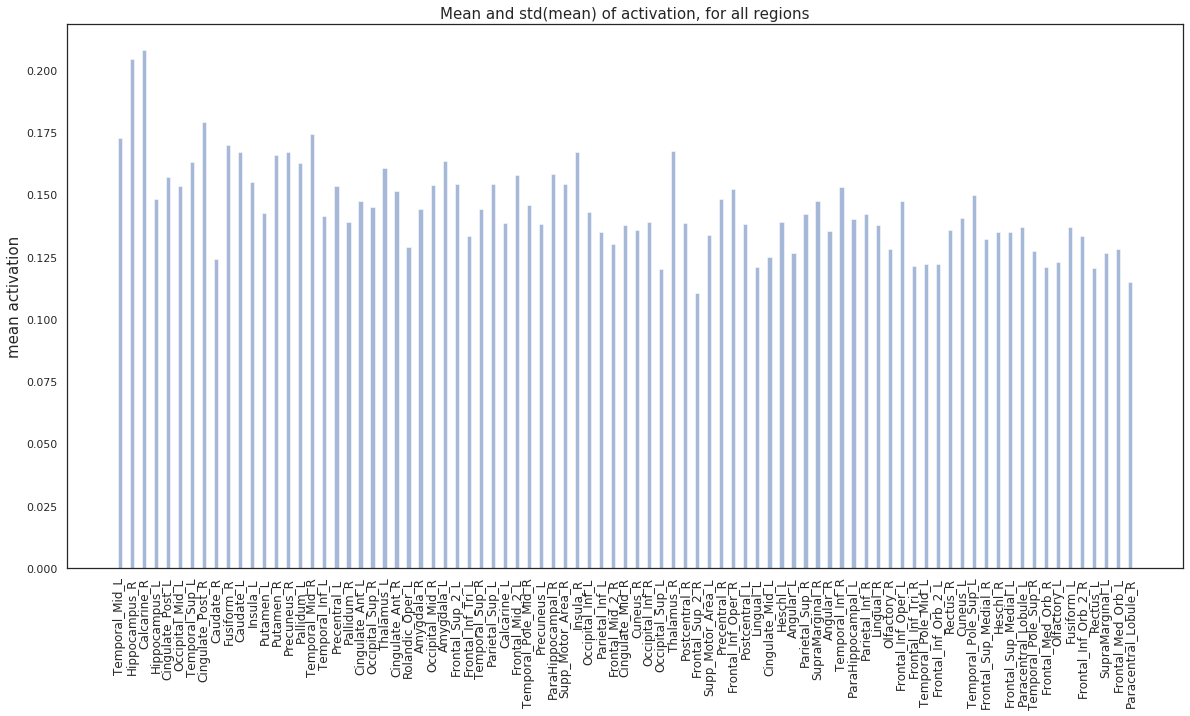

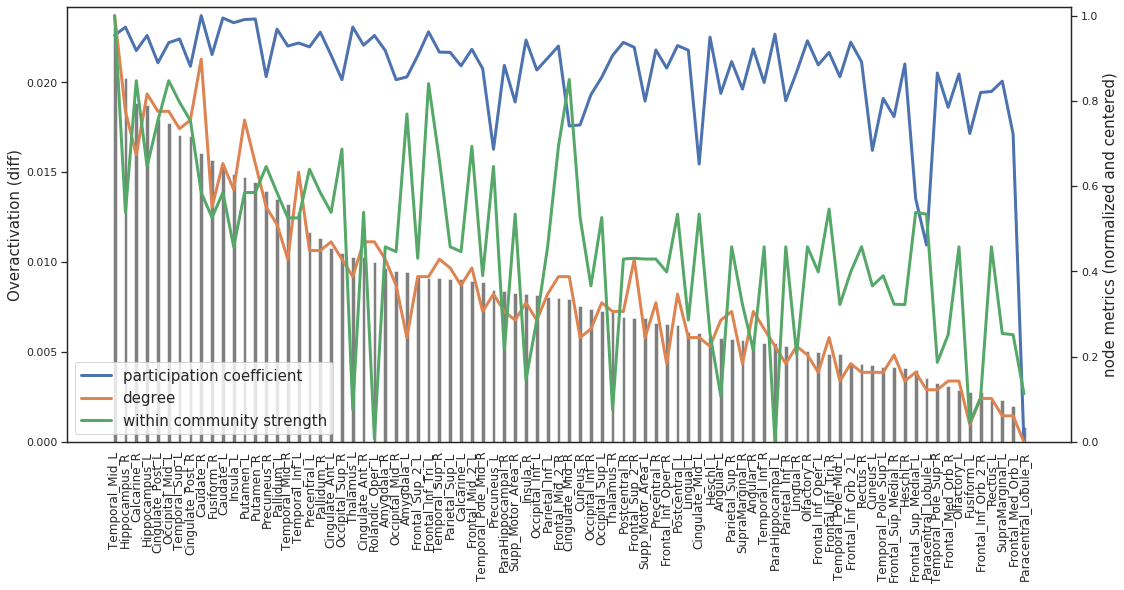

In [16]:
#figure with CI - BP (i.e. difference of overactivations: not considering the difference percentage)

from utils_graph_measures import *
sns.set(style='white')

diff_change = {node: total_activation_CI[node] - total_activation_BP[node] for node in total_activation_BP.keys()} #diff_change by opposition to diff_percent (by default, d_overactivation is diff_percent and not diff_change)

# print("Sorted list of regions from the most overactivated to the least overactivated:")
# print(list(diff_change.keys()))


diff_change = sort_dict_by_value(diff_change) #not sure it's necessary

# plot_dict_ordered(diff_change, ylabel='Overactivation (diff)')


#Activation under BP
plot_dict_ordered(total_activation_BP, d_order=diff_change, 
                  ylabel='mean activation', title_fig='Mean and std(mean) of activation, for all regions')


#Overactivation and graph measures on top of each other
list_measures = ["participation_coefficient_undirected", "degree", "within_community_strength_undirected"] #fun_measures.keys()
plot_dict_ordered_with_additional_curve(diff_change, res.graph_G, ylabel='Overactivation (diff)', list_measures=list_measures)#, savefig="FigS6A", type_graph=graph_G.type_graph)

In [19]:
#looking at the degree of brain regions in the graph (to see whether the most overactivated regions are simply the ones with the highest degree)

#Most connected nodes
degree_nodes = {node: res.graph_G.degree(node) for node in res.graph_G.nodes}
sorted_degree_nodes = sort_dict_by_value(degree_nodes) #sort by value
# print(sorted_degree_nodes)

#print the n most connected regions
n_most_connected_regions = 11
most_connected_regions = list(sorted_degree_nodes.keys())[:n_most_connected_regions]
print("{} most connected regions: ".format(n_most_connected_regions))
print(most_connected_regions)

11 most connected regions: 
['Temporal_Mid_L', 'Caudate_R', 'Hippocampus_L', 'Cingulate_Post_L', 'Hippocampus_R', 'Occipital_Mid_L', 'Cingulate_Post_R', 'Putamen_L', 'Temporal_Sup_L', 'Calcarine_R', 'Caudate_L']


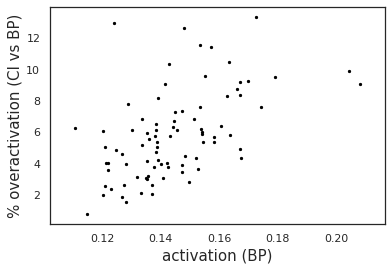

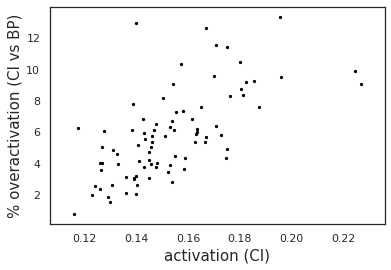

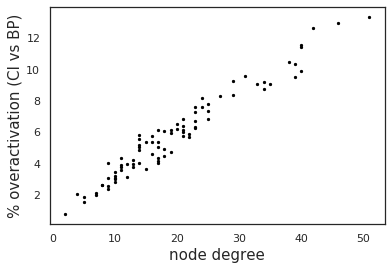

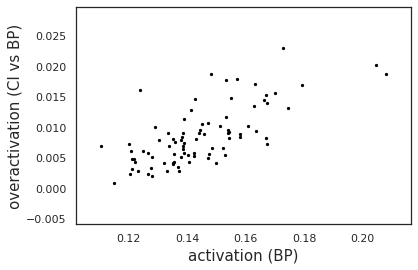

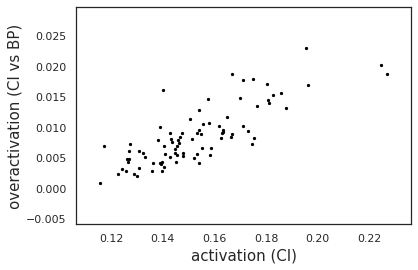

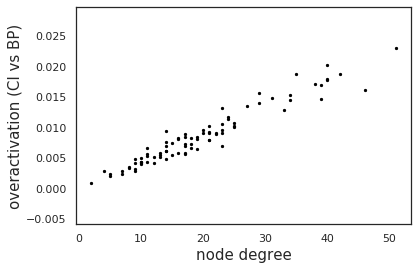

In [20]:
#Activation vs overactivation: are they correlated variables?


########### With percent change ###############

plt.scatter(list({key:total_activation_BP[key] for key in d_overactivation.keys()}.values()), list(d_overactivation.values()), color='black', s=5)
plt.xlabel("activation (BP)", size=15)
plt.ylabel("% overactivation (CI vs BP)", size=15)
plt.show()

plt.scatter(list({key:total_activation_CI[key] for key in d_overactivation.keys()}.values()), list(d_overactivation.values()), color='black', s=5)
plt.xlabel("activation (CI)", size=15)
plt.ylabel("% overactivation (CI vs BP)", size=15)
plt.show()

assert set(degree_nodes.keys()) == set(d_overactivation.keys())
plt.scatter(list({key:degree_nodes[key] for key in d_overactivation.keys()}.values()), list(d_overactivation.values()), color='black', s=5)
plt.xlabel("node degree", size=15)
plt.ylabel("% overactivation (CI vs BP)", size=15)
plt.show()

########### With diff ##########################

plt.scatter(list({key:total_activation_BP[key] for key in diff_change.keys()}.values()), list(diff_change.values()), color='black', s=5)
plt.xlabel("activation (BP)", size=15)
plt.ylabel("overactivation (CI vs BP)", size=15)
plt.show()

plt.scatter(list({key:total_activation_CI[key] for key in diff_change.keys()}.values()), list(diff_change.values()), color='black', s=5)
plt.xlabel("activation (CI)", size=15)
plt.ylabel("overactivation (CI vs BP)", size=15)
plt.show()

assert set(degree_nodes.keys()) == set(diff_change.keys())
plt.scatter(list({key:degree_nodes[key] for key in diff_change.keys()}.values()), list(diff_change.values()), color='black', s=5)
plt.xlabel("node degree", size=15)
plt.ylabel("overactivation (CI vs BP)", size=15)
plt.show()

k = 0.05


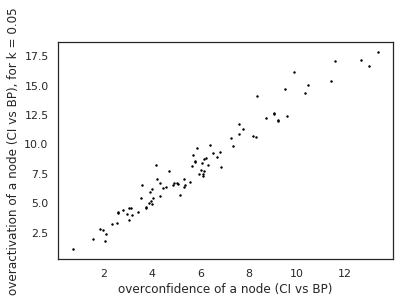

In [21]:
#plot overconfidence vs overactivation

if k == np.inf:
    print("This plot makes no sense as k = inf")
print("k = {}".format(k))
assert k != np.inf
plt.scatter(d_overactivation.values(), d_overconfidence.values(), color='black', s=2)
plt.xlabel('overconfidence of a node (CI vs BP)')
plt.ylabel('overactivation of a node (CI vs BP), for k = {}'.format(k))
plt.show()

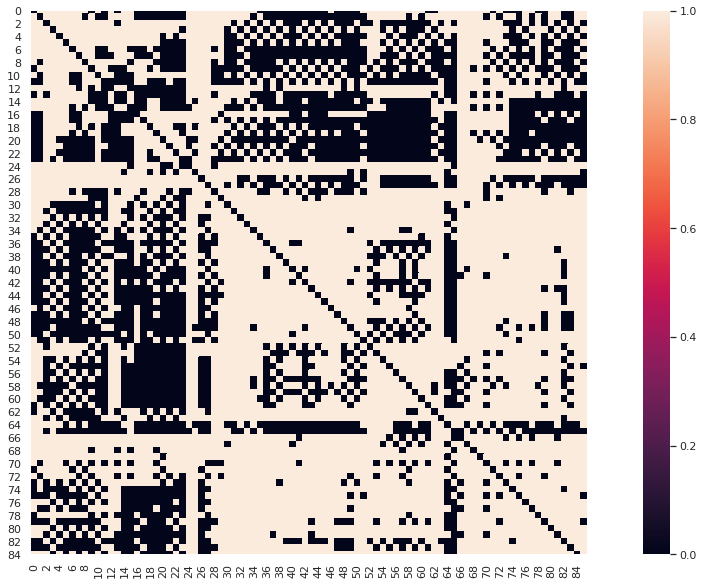

11 most overactivated regions (in %):
['Precentral_L', 'Precentral_R', 'Frontal_Sup_2_L', 'Frontal_Sup_2_R', 'Frontal_Mid_2_L', 'Frontal_Mid_2_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_2_L']
Associated indices:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Associated indices (sorted):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

11 most overactivated regions:
['Temporal_Mid_L', 'Hippocampus_R', 'Calcarine_R', 'Hippocampus_L', 'Cingulate_Post_L', 'Occipital_Mid_L', 'Temporal_Sup_L', 'Cingulate_Post_R', 'Caudate_R', 'Fusiform_R', 'Caudate_L']
Associated indices:
[80, 33, 39, 32, 30, 46, 76, 31, 67, 51, 66]
Associated indices (sorted):
[30, 31, 32, 33, 39, 46, 51, 66, 67, 76, 80]


In [22]:
import seaborn as sns

type_graph = 'realistic_connectome_AAL2' #'small_world'
graph_G = generate_graph(type_graph)
adjacency_matrix = nx.to_numpy_matrix(graph_G, dtype=np.bool, nodelist=list(graph_G.nodes))
plt.figure(figsize=(20,10))
ax = sns.heatmap(
    adjacency_matrix,
    square=True
)
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right')
plt.show()

#get the indices of the most active regions
# print("Most active regions:")
# print(most_active_regions)
# print("Associated indices:")
# print([list_names.index(el) for el in most_active_regions])
# print("Associated indices (sorted):")
# print(sorted([list_names.index(el) for el in most_active_regions]))


# print("Sorted list of regions from the most overactivated (in %) to the least overactivated:")
# print(list(d_overactivation.keys()))
# print("Associated indices:")
# print([list(mapping_nodes.values()).index(el) for el in list(d_overactivation.keys())])
# print("Sorted list of regions from the most overactivated to the least overactivated:")
# print(list(diff_change.keys()))
# print("Associated indices:")
# print([list(mapping_nodes.values()).index(el) for el in list(diff_change.keys())])

n_select = 11
print("{} most overactivated regions (in %):".format(n_select))
print(list(d_overactivation.keys())[:n_select])
print("Associated indices:")
print([list(mapping_nodes.values()).index(el) for el in list(d_overactivation.keys())[:n_select]])
print("Associated indices (sorted):")
print(sorted([list(mapping_nodes.values()).index(el) for el in list(d_overactivation.keys())[:n_select]]))

print()

print("{} most overactivated regions:".format(n_select))
print(list(diff_change.keys())[:n_select])
print("Associated indices:")
print([list(mapping_nodes.values()).index(el) for el in list(diff_change.keys())[:n_select]])
print("Associated indices (sorted):")
print(sorted([list(mapping_nodes.values()).index(el) for el in list(diff_change.keys())[:n_select]]))

Question: why is there such an intense connectivity? It is probably because of the chosen threshold for binarize_realistic_connectome

--> Most overactivated regions: 'Occipital_Mid_ L','Caudate_R', 'Calcarine_R', 'Temporal_Sup_L', 'Putamen_L','Temporal_Mid_L', 'Hippocampus_L', 'Hippocampus_R
The most overactivated regions correspond approximately to the most connected regions.

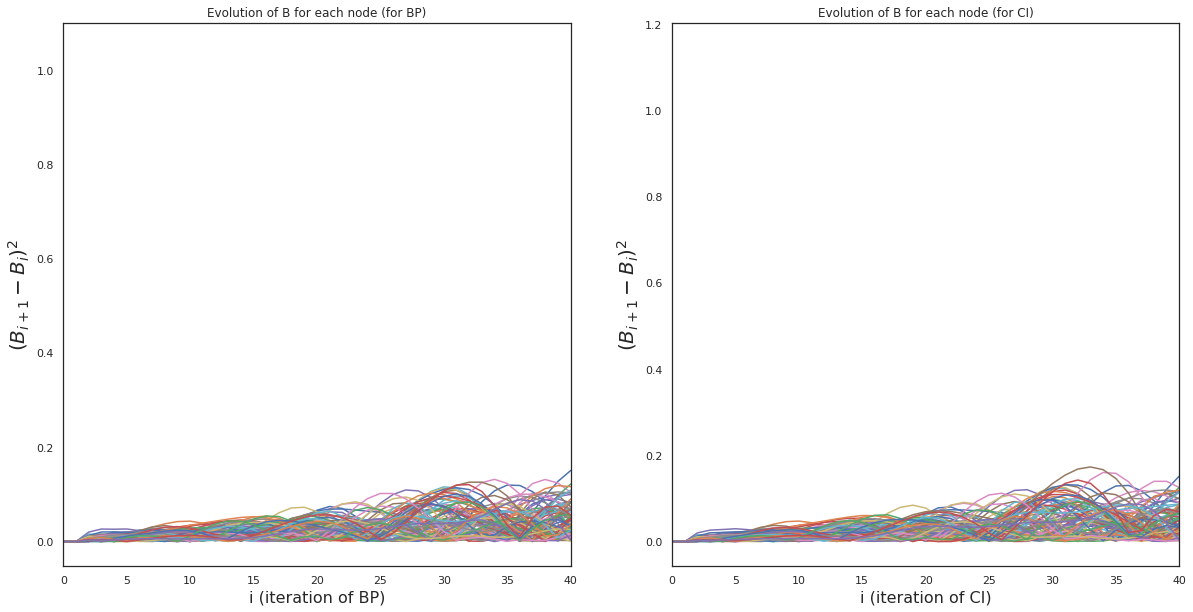

In [23]:
fig = plt.figure(figsize=(20,10))

begin = 0

plt.subplot(1,2,1)
for key, val in activations_history_BP.items():
    plt.plot(val[begin:], label=key)
# plt.legend()
plt.title('Evolution of B for each node (for BP)')
plt.xlim(0, 40)
# plt.xlim(400, 500)
# plt.ylim(-1.5, 1.5)
plt.ylabel(r'$(B_{i+1} - B_{i})^2$', size=20)
plt.xlabel('i (iteration of BP)', size=16)

plt.subplot(1,2,2)
for key, val in activations_history_CI.items():
    plt.plot(val[begin:], label=key)
# plt.legend()
plt.title('Evolution of B for each node (for CI)')
plt.xlim(0, 40)
# plt.xlim(400, 500)
# plt.ylim(-1.5, 1.5)
plt.ylabel(r'$(B_{i+1} - B_{i})^2$', size=20)
plt.xlabel('i (iteration of CI)', size=16)

plt.show()

In [24]:
updates_BP = res.compute_updates_BP()
updates_CI = res.compute_updates_CI() 
sum_squared_updates_BP = sum_squared_updates(updates_BP, begin=begin)
sum_squared_updates_CI = sum_squared_updates(updates_CI, begin=begin)
sum_abs_updates_BP = sum_abs_updates(updates_BP, begin=begin)
sum_abs_updates_CI = sum_abs_updates(updates_CI, begin=begin)

Not plotting the left subplot (M_ext is not constant)


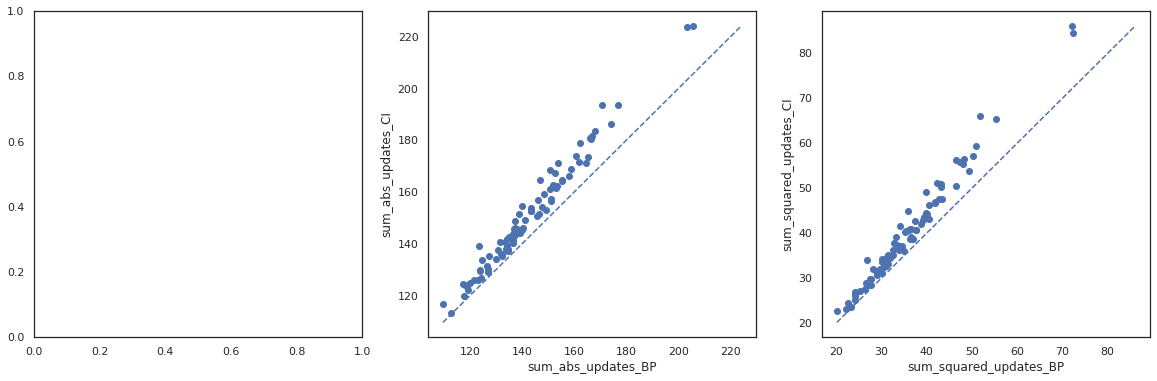

################### Measure type: centrality ######################
degree_centrality
neighbors_length_2
neighbors_length_3
neighbors_length_4
closeness_centrality
closeness_centrality_undirected
betweenness_centrality
betweenness_centrality_undirected
load_centrality
load_centrality_undirected
harmonic_centrality
harmonic_centrality_undirected
local_reaching_centrality
local_reaching_centrality_undirected
participation_coefficient_undirected
within_community_strength_undirected


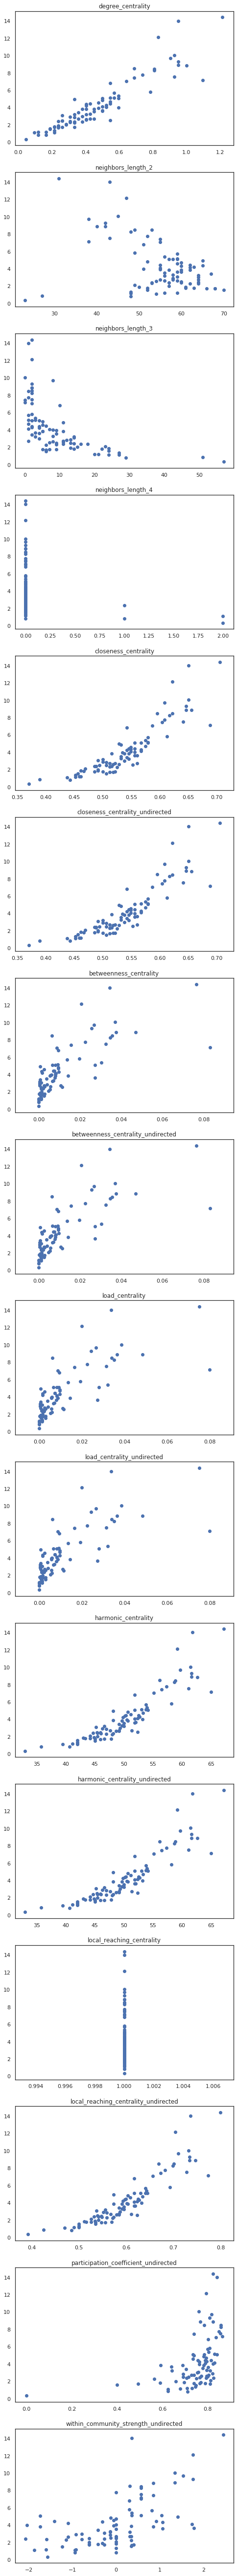

################### Measure type: degree ######################
degree
in_degree
out_degree


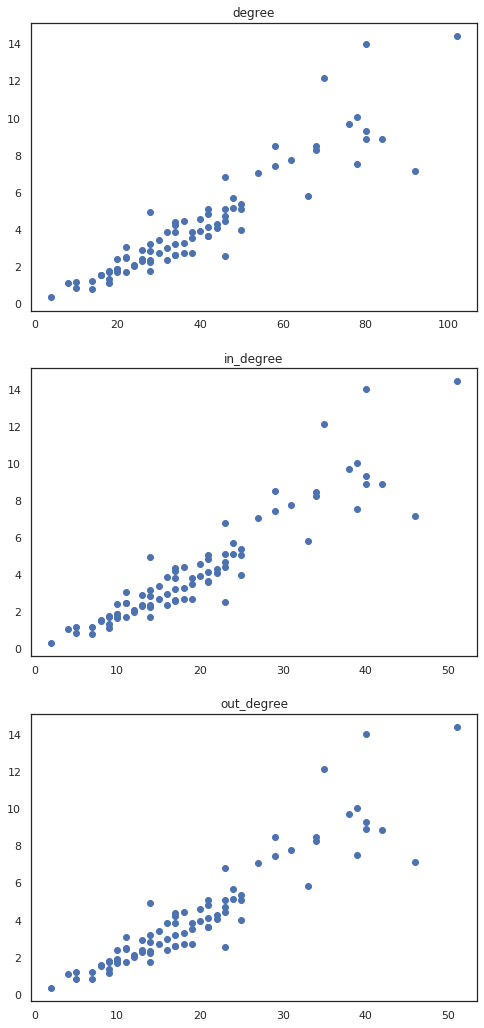

################### Measure type: clustering ######################
clustering
clustering_undirected
square_clustering
square_clustering_undirected


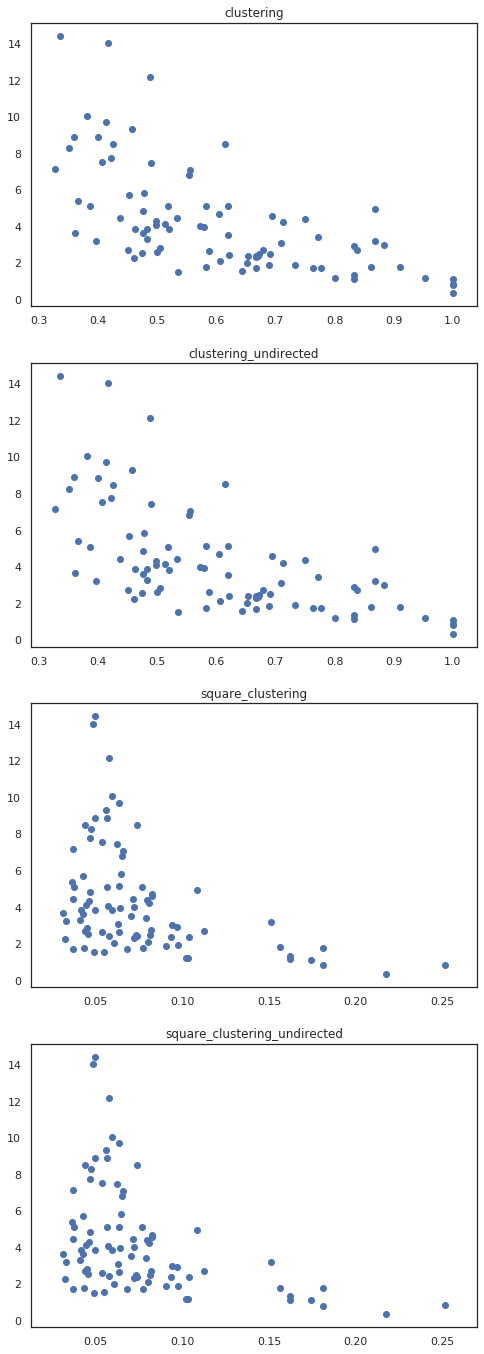

################### Measure type: assortativity ######################
average_neighbor_degree


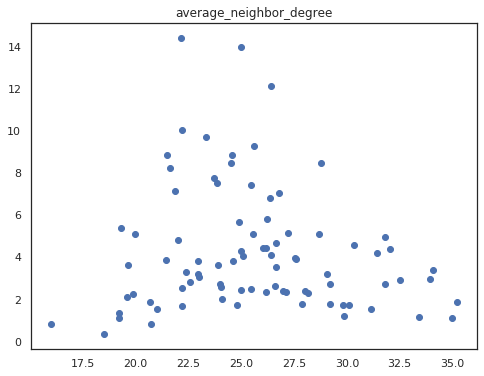

In [27]:
from utils_graph_measures import *

def plt_scatter(x, y, xlabel='', ylabel=''):
    """
    Scatter plot + identity line
    """
    if type(x) == dict and type(y) == dict:
        assert list(x.keys()) == list(y.keys())
        x = list(x.values())
        y = list(y.values())
    plt.scatter(x, y)
    if xlabel != '':
        plt.xlabel(xlabel)
    if ylabel != '':
        plt.ylabel(ylabel)
    xx = np.linspace(np.min([x, y]), np.max([x, y]),2)
    plt.plot(xx, xx, linestyle='--')
#     plt.show()

def diff_dict(d1, d2):
    assert list(d1.keys()) == list(d2.keys())
    return dict(zip(list(d1.keys()), np.array(list(d1.values())) - np.array(list(d2.values()))))

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
if len(res.M_ext[list(res.M_ext.keys())[0]]) == 1:
    plt_scatter(res.B_BP, res.B_CI, 'B_BP', 'B_CI') #this code only makes sense if M_ext is a constant (we consider then the convergence values res.B_BP and res.B_CI)
else:
    print("Not plotting the left subplot (M_ext is not constant)")
plt.subplot(1, 3, 2)
plt_scatter(sum_abs_updates_BP, sum_abs_updates_CI, 'sum_abs_updates_BP', 'sum_abs_updates_CI')
plt.subplot(1, 3, 3)
plt_scatter(sum_squared_updates_BP, sum_squared_updates_CI, 'sum_squared_updates_BP', 'sum_squared_updates_CI')
plt.show()


y = diff_dict(sum_squared_updates_CI, sum_squared_updates_BP)
# y = diff_dict(sum_abs_updates_CI, sum_abs_updates_BP)
# y = diff_dict(B_CI, B_BP)
# y = B_BP

assert list(y.keys()) == list(res.graph_G.nodes)
# assert set(list(y.keys())) == set(list(res.graph_G.nodes))
# if list(y.keys()) != list(res.graph_G.nodes):
#     print("problem")
#     sys.exit()

graph_G_dir = G_orient_and_double(res.graph_G)
dict_graph_measures = {'centrality': get_centrality_measures(graph_G_dir),
                       'degree': get_degree_measures(graph_G_dir),
                       'clustering': get_clustering_measures(graph_G_dir),
                       'assortativity': get_assortativity_measures(graph_G_dir)
                      }

for measure_type, dict_x in dict_graph_measures.items():
    print("################### Measure type: {} ######################".format(measure_type))
    plt.figure(figsize=(8, 6*len(dict_x)))
    for i, measure_name in enumerate(list(dict_x.keys())):
        print(measure_name)
        x = dict_x[measure_name]
#         print(x)
#         assert list(dict(x).keys()) == list(res.graph_G.nodes)
        assert set(list(dict(x).keys())) == set(list(res.graph_G.nodes))
        if list(x.keys()) != list(res.graph_G.nodes): #dict(x)
#             print("reordering")
#             print(list(x.keys()))
#             print(list(res.graph_G.nodes.keys()))
            x = {key: x[key] for key in res.graph_G.nodes.keys()}
        plt.subplot(len(dict_x), 1, i+1)
        plt.scatter(x.values(), y.values()) #dict(x)
    #     plt.ylabel("sum_squared_updates_CI - sum_squared_updates_BP")
        plt.title(measure_name)
    plt.show()

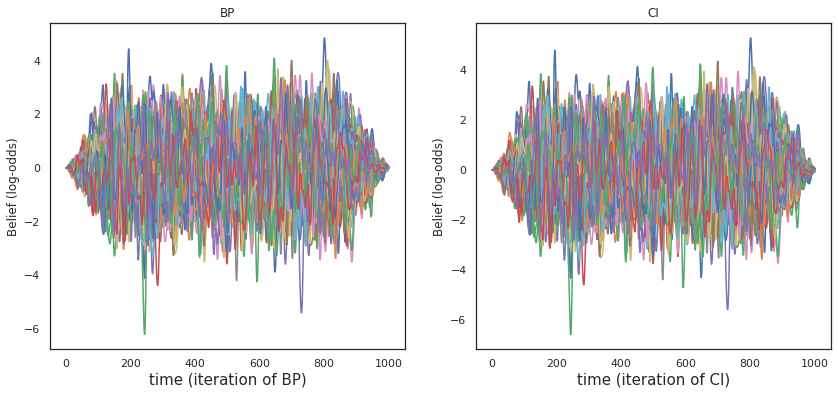

In [33]:
#plot the temporal evolution of B
plot_B_history_BP_B_history_CI(res.B_history_BP, res.B_history_CI)

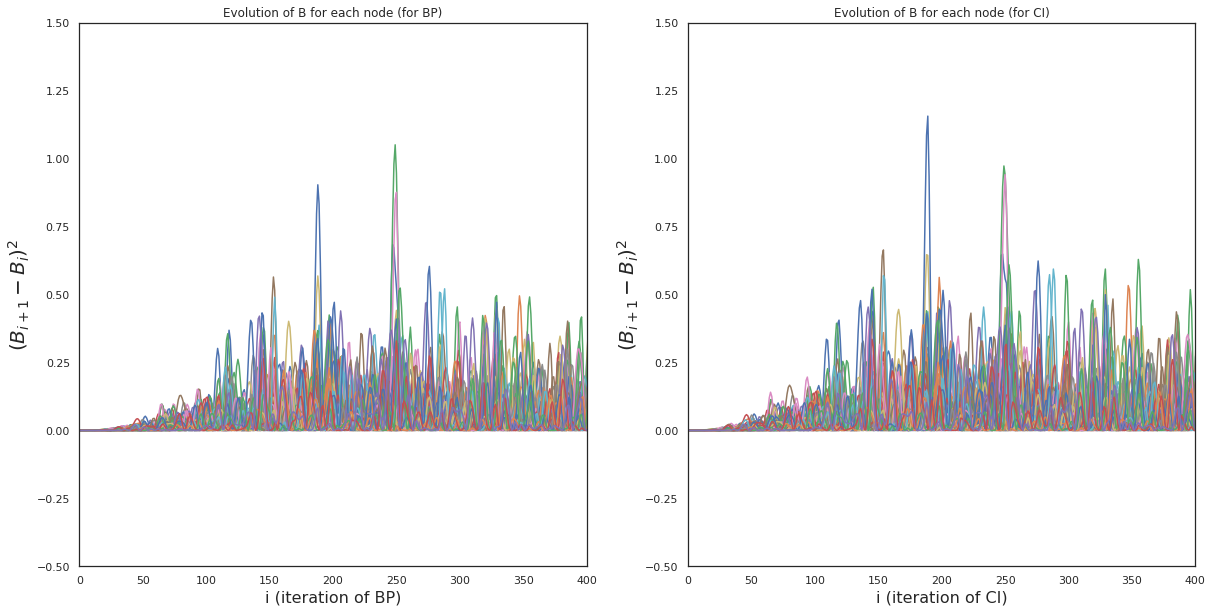

In [34]:
#"node activations" i.e. (B_i+1 - B_i)^2

fig = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
for key, val in res.B_history_BP.items():
    plt.plot((val[1:] - val[:-1])**2, label=key)
# plt.legend()
plt.title('Evolution of B for each node (for BP)')
plt.xlim(0, 400)
plt.ylim(-.5, 1.5)
plt.ylabel(r'$(B_{i+1} - B_{i})^2$', size=20)
plt.xlabel('i (iteration of BP)', size=16)

plt.subplot(1,2,2)
for key, val in res.B_history_CI.items():
    plt.plot((val[1:] - val[:-1])**2, label=key)
# plt.legend()
plt.title('Evolution of B for each node (for CI)')
plt.xlim(0, 400)
plt.ylim(-.5, 1.5)
plt.ylabel(r'$(B_{i+1} - B_{i})^2$', size=20)
plt.xlabel('i (iteration of CI)', size=16)

plt.show()

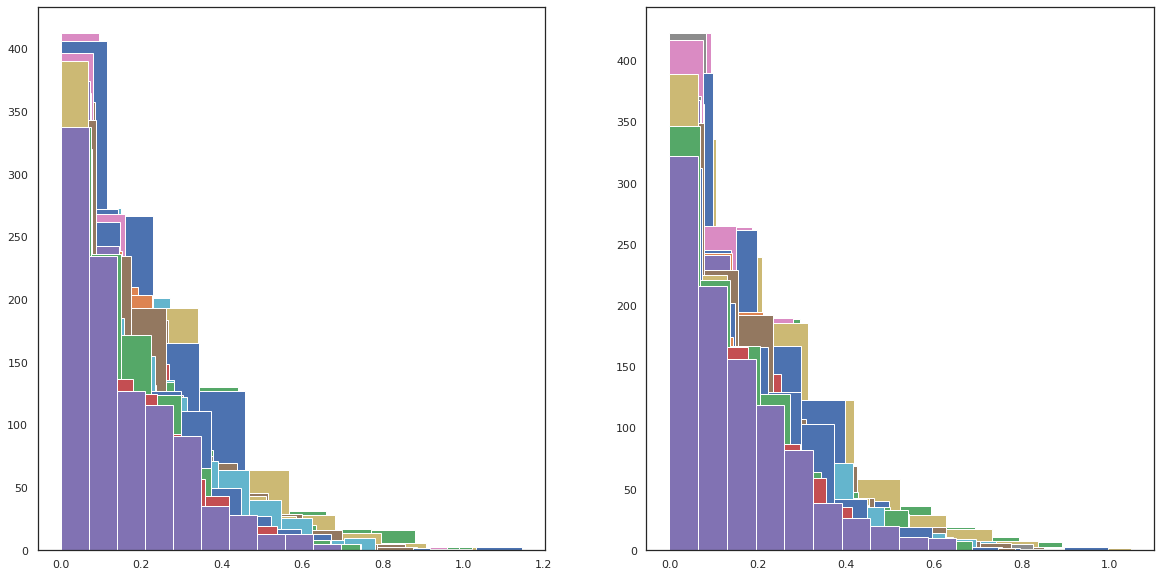

In [35]:
#distribution of the "node activations"

fig = plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
for key, val in activations_history_CI.items():
    plt.hist(val, bins=10, label=key)

plt.subplot(1,2,2)
for key, val in activations_history_BP.items():
    plt.hist(val, bins=10, label=key)

plt.show()

The node activations (or B_history) are quite similar between BP and CI. That is why we look at differences (in absolute value or in percentage)

### Plot a histogram (violin plot) of the overactivation for all types of nodes (connector hubs, local hubs and other nodes)

In [36]:
load_df = False

if load_df == False:
    #Create df
    graph_G = res.graph_G

    print("Classification from [Bertolero et al, 2018]")
    print("- connector hubs:", find_connector_hubs(graph_G))
    print("- local hubs", find_local_hubs(graph_G))

    assert set(list(d_overactivation.keys())) == set(list(d_overconfidence.keys()))
    # d = {node: [d_overactivation[node], d_overconfidence[node], type_connector_hub(G, node), type_local_hub(G, node)] for node in d_overactivation.keys()}
    # df = pd.DataFrame.from_dict(d, orient='index', 
    #                             columns=['overactivation', 'overconfidence', 'type_connector_hub', 'type_local_hub'])
    d = {node: [d_overactivation[node], d_overconfidence[node], type_hub(graph_G, node)] for node in d_overactivation.keys()}
    df = pd.DataFrame.from_dict(d, orient='index', 
                                columns=['overactivation', 'overconfidence', 'type_node'])
    # display(df)

    # df.to_pickle('dataframe_violinplot.pkl') #save file
    
else:
    df = pd.read_pickle('dataframe_violinplot.pkl') #read file

Classification from [Bertolero et al, 2018]
- connector hubs: ['Caudate_R', 'Caudate_L', 'Putamen_R', 'Putamen_L', 'Insula_L', 'Thalamus_L', 'Hippocampus_R', 'Pallidum_L', 'Frontal_Inf_Tri_L', 'Pallidum_R', 'ParaHippocampal_L', 'Temporal_Mid_L', 'Hippocampus_L', 'Rolandic_Oper_L', 'Heschl_L', 'Temporal_Sup_L', 'Insula_R']
- local hubs ['Temporal_Mid_L', 'Cingulate_Mid_R', 'Calcarine_R', 'Occipital_Mid_L', 'Frontal_Inf_Tri_L', 'Temporal_Sup_L', 'Amygdala_L', 'Cingulate_Post_L', 'Cingulate_Post_R', 'Frontal_Mid_2_L', 'Frontal_Mid_2_R', 'Occipital_Sup_R', 'Temporal_Sup_R', 'Hippocampus_L', 'Precuneus_L', 'Precuneus_R', 'Precentral_L']


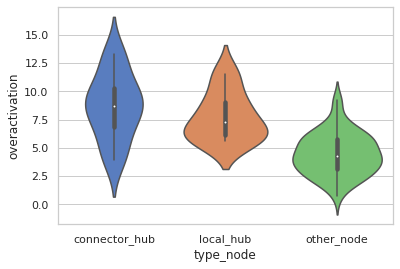

In [37]:
#Violin plot of df

import seaborn as sns
sns.set(style="whitegrid")

# # sns.violinplot(y='overactivation', hue='type_connector_hub', data=df, palette='muted')
# sns.violinplot(x='type_connector_hub', y='overactivation', data=df, palette='muted', order=['connector_hub', 'other_node'])
# plt.show()
# sns.violinplot(x='type_connector_hub', y='overconfidence', data=df, palette='muted', order=['connector_hub', 'other_node'])
# plt.show()

# sns.violinplot(x='type_local_hub', y='overactivation', data=df, palette='muted', order=['local_hub', 'other_node'])
# plt.show()
# sns.violinplot(x='type_local_hub', y='overconfidence', data=df, palette='muted', order=['local_hub', 'other_node'])
# plt.show()


sns.violinplot(x='type_node', y='overactivation', data=df, palette='muted', order=['connector_hub', 'local_hub', 'other_node'])
plt.show()

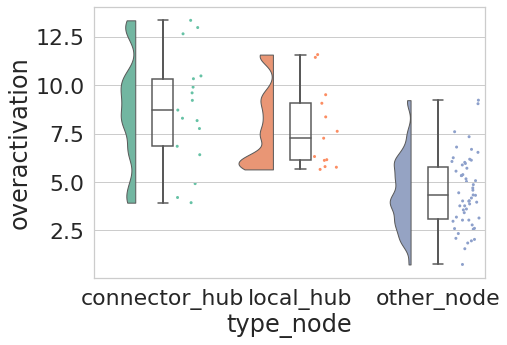

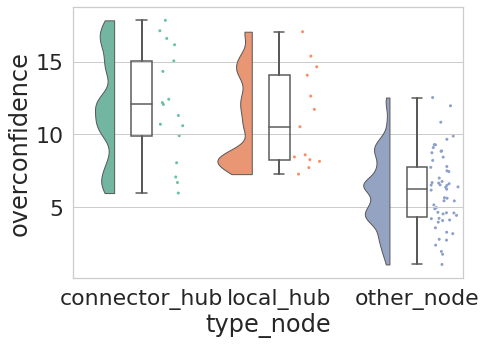

In [38]:
#RainCloud plot

import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
#sns.set(style="darkgrid")
#sns.set(style="whitegrid")
#sns.set_style("white")
sns.set(style="whitegrid",font_scale=2)
import matplotlib.collections as clt
import ptitprince as pt

savefigs = False

ort = "v"
pal = "Set2"
sigma = .2 #std of the smoothing kernel used to plot the probability distribution function of the data
move = 0.2 #0.2  #to move the rain away from the boxplot

# mapping = {'type_local_hub': 'local_hub', 'type_connector_hub':'connector_hub'}
# for x in ["type_local_hub", "type_connector_hub"]:
#     for y in ["overactivation", "overconfidence"]:
#         f, ax = plt.subplots(figsize=(7, 5))
#         ax = pt.RainCloud(x = x, y = y, data = df, palette = pal, bw = sigma,
#                          width_viol = .5, ax = ax, orient = ort, move = move, order=[mapping[x], 'other_node'])
#         if savefigs:
#             plt.savefig('figure_raincloudpoint.png', bbox_inches='tight')
            
for y in ["overactivation", "overconfidence"]:
    f, ax = plt.subplots(figsize=(7, 5))
    ax = pt.RainCloud(x='type_node', y = y, data = df, palette = pal, bw = sigma,
                     width_viol = .5, ax = ax, orient = ort, move = move, order=['connector_hub', 'local_hub', 'other_node'])


In [39]:
#RainCloud plot

import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
sns.set(style="whitegrid",font_scale=2) #sns.set(style="darkgrid") #sns.set(style="whitegrid") #sns.set_style("white")
import matplotlib.collections as clt
import ptitprince as pt


def perso_violin_plot(df, y="overconfidence", which=None, strip_move=False):

    df['new_col'] = 1 #constant column (in order to put hub and other_node on top of each other)
    df['type_node'] = df['type_node'].replace({'other_node': 'other node',
                                               'local_hub': 'local hub',
                                               'connector_hub': 'connector hub'})
    df = df.rename(columns={'type_node': 'node type'})
    
    ort = "v"
    pal = "Set2"
    sigma = .4 #std of the smoothing kernel used to plot the probability distribution function of the data
    x = 'new_col'
    dodge = True

    # mapping = {'type_local_hub': 'local_hub', 'type_connector_hub':'connector_hub'}
    # for hue in ["type_local_hub", "type_connector_hub"]:
    #     for y in ["overactivation", "overconfidence"]:
    #         hue_order=[mapping[hue], 'other_node']
    #         f, ax = plt.subplots(figsize=(7, 5))
    # #         ax = pt.RainCloud(x = x, y = y, data = df, palette = pal, bw = sigma, hue=hue, hue_order=hue_order,
    # #                           width_viol = .4, width_box=0.06, point_size=4,
    # #                           ax = ax, orient = ort, move = move, dodge=dodge, alpha=0.7)#, order=[mapping[x], 'other_node'])
    #         #I added the option invertviolin (and possibly others) by modifying the code of PtitPrince.py in ~/anaconda3/lib/python3.7/site-packages
    #         ax = pt.RainCloud(x = x, y = y, data = df, palette = pal, bw = sigma, hue=hue, hue_order=hue_order,
    #                           width_viol = .4, width_box=0.06, point_size=4,
    #                           ax = ax, orient = "v", move = -0.15, jitter=0.05,
    #                           offset=-0.14,
    #                           dodge=dodge, alpha=0.75, invertviolin=True, violin_edgecolor = 'none', strip_move=strip_move,
    #                           showcaps=False
    #                          )#, order=[mapping[x], 'other_node'])
    #         plt.xlim(-.3,.5)
    #         plt.xticks([])
    #         plt.xlabel('')

#     for y in ["overactivation", "overconfidence"]:
    for y in [y]:
#         hue_order = ['other_node', 'local_hub', 'connector_hub']
        hue_order = ['connector hub', 'local hub', 'other node']
        f, ax = plt.subplots(figsize=(7, 5))
    #     ax = pt.RainCloud(x = x, y = y, data = df, palette = pal, bw = sigma, hue=hue, hue_order=hue_order,
    #                       width_viol = .4, width_box=0.06, point_size=4,
    #                       ax = ax, orient = ort, move = move, dodge=dodge, alpha=0.7)#, order=[mapping[x], 'other_node'])
        #I added the option invertviolin (and possibly others) by modifying the code of PtitPrince.py in ~/anaconda3/lib/python3.7/site-packages/ptitprince/
        ax = pt.RainCloud(x = x, y = y, data = df, palette = pal, bw = sigma, 
                          hue='node type', #'type_node', 
                          hue_order=hue_order,
                          width_viol = .4, width_box=0.1, point_size=4,
                          ax = ax, orient = "v", move = -0.15, jitter=0.05,
                          offset=-0.14,
                          dodge=dodge, alpha=0.75, invertviolin=True, violin_edgecolor = 'none', strip_move=strip_move,
                          showcaps=False
                         )#, order=[mapping[x], 'other_node'])
        #TODO: once the changes are ok, go back to pt.RainCloud
        plt.xlim(-.3,.5)
        plt.xticks([])
        plt.xlabel('')
        if y == "overconfidence" and which == "percent":
            plt.ylabel("overconfidence (%)")
        elif y == "overactivation" and which == "percent":
            plt.ylabel("overactivation (%)")
        else:
            plt.ylabel(y)
        if which == 'percent':
            plt.ylim(bottom=0)

AttributeError: 'PolyCollection' object has no property 'invertviolin'

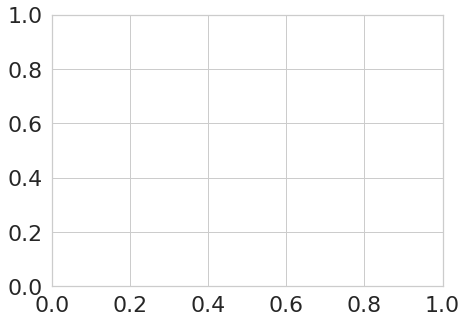

In [40]:
for y in ["overactivation", "overconfidence"]:
    perso_violin_plot(df, y=y, which=which, strip_move=True)
    plt.show()

### Linear regression of overactivation vs graph measures

In [41]:
#Linear Regression: regress sum_squared_updates_CI - sum_squared_updates_BP vs graph measures

import numpy as np
from sklearn.linear_model import LinearRegression
from utils_graph_measures import all_fun_measures

all_measures_graph = {}
for measure_name, fun_measure in all_fun_measures.items():
    all_measures_graph[measure_name] = fun_measure(res.graph_G)
    assert list(all_measures_graph[measure_name].keys()) == list(res.graph_G.nodes())
    all_measures_graph[measure_name] = all_measures_graph[measure_name] #list(all_measures_graph[measure_name].values())
# print(all_measures_graph)

y = diff_dict(sum_squared_updates_CI, sum_squared_updates_BP)
assert list(y.keys()) == list(res.graph_G.nodes())

x = np.array([list(val.values()) 
              for key, val in all_measures_graph.items()]).T #TODO (maybe): center and normalize the values by measure_name?
y = np.array(list(y.values()))
# print(x.shape, y.shape)

reg = LinearRegression(fit_intercept=True).fit(x, y) #with constant
# reg = LinearRegression(fit_intercept=False).fit(x, y) #without constant

# print(list(all_fun_measures.keys()))
# print(list(all_fun_measures.keys())+['constant'])

# print(reg.score(x, y))
# print(reg.coef_) #does not include the constant (in the case fit_intercept=True)
# print((reg.coef_).shape)
pprint(dict(zip(list(all_fun_measures.keys()), reg.coef_)))

# print(reg.intercept_)
# print(reg.predict(np.array([[3, 5]])))


#---> Bad measure (at least with my graphs): local_reaching_centrality, square_clustering

{'average_neighbor_degree': 0.0814361572265625,
 'betweenness_centrality': 618985160.1479645,
 'betweenness_centrality_undirected': -618985673.6853807,
 'closeness_centrality': -967074811.2016097,
 'closeness_centrality_undirected': 967074887.1680745,
 'clustering': 1103434184.4982874,
 'clustering_undirected': -1103434183.4526405,
 'degree_centrality': -143153468071.1993,
 'global_average_clustering': 59510703038.87958,
 'global_average_shortest_path_length': 119021406077.75922,
 'global_degree_assortativity_coefficient': 7438837879.859951,
 'global_degree_pearson_correlation_coefficient': 14877675759.719898,
 'global_density': -14877675759.719902,
 'global_reaching_centrality': -29755351519.439804,
 'global_transitivity': 59510703038.87959,
 'harmonic_centrality': 2706938920207.503,
 'harmonic_centrality_undirected': 2706937186226.294,
 'load_centrality': 63535235.42873208,
 'load_centrality_undirected': -63534764.59508021,
 'local_reaching_centrality': -49544780270.55577,
 'local_re

# Taking many simulations to average out the potential random effects
Here we average over graph weights (orientation, but not structure) and over sensory inputs M_ext (both which vary with time and between simulations)

In [1]:
#Simulate BP and CI for a given graph
#(here we save everything, including frustrated or bistable networks)

from simulate import *
from compute_effects_CI_vs_BP import *
from utils_stability_analysis import *
from utils_find_hubs import *
from utils_save_fig import save_fig
from utils_dict import *
from utils_plot_dict import *
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline 

def sig(x):
    return 1 / (1+np.exp(-np.array(x)))


#Arguments for the simulation
# type_graph = 'modular_SW'
type_graph = 'realistic_connectome_AAL2' #'realistic_connectome_HCP'
alpha_c, alpha_d = (0.6, 0.6) #needs to be different from (1, 1), otherwise overactivation = 0
type_M_ext = 'gaussian_process_by_periods_not_all_nodes' #'gaussian_process_by_periods' #'poisson_process', 'gaussian_process' #'white_noise'
keep_history = True
begin = 0 #50
method_weighting='bimodal_w'
remove_cerebellum_and_vermis = True
remove_ofc = True
binarize_realistic_connectome = True
T_period = 1000


load_data = True #if True, load simulate data. if False, launch a new simulation.
if not load_data:
    print("Simulating new data (not advised because long - run instead compute_effects.py {})".format(type_graph))
else:
    print("Loading previously simulated data")
    suffix_folder = get_suffix_to_folder(type_graph, remove_cerebellum_and_vermis, remove_ofc)
    check_folder_exists(path_dir_save) #create folder if it does not exist
    if (type_graph + suffix_folder in os.listdir(path_dir_save)) == False:
        print("There are no simulations to load - generate data with the following command: 'python compute_effects_CI_vs_BP.py {}'. Alternative (not advised): change load_data to False".format(type_graph))
        sys.exit()
    list_files = os.listdir(path_dir_save + type_graph + suffix_folder + '/')
    list_files = [el for el in list_files if '.pkl' in el]
    list_files = [el for el in list_files if type_M_ext in el] #select only files with the same generation process for M_ext
    print("({} files to load)".format(len(list_files)))
    
if not load_data:
    n_simulations = 10#0 #put back 50
    iterator_simulations = range(n_simulations)
else:
    iterator_simulations = range(len(list_files))

    
df_all_simulations = None
cpt = 0 #counts the number of unfiltered simulations

for i_simulation in iterator_simulations:
#     print("simulation #{} out of {}".format(i_simulation+1, len(iterator_simulations)))
    #Percentage bar
    sys.stdout.write('\r')
    j = (i_simulation + 1) / len(iterator_simulations)
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    
    if not load_data:
        #Simulate
        res = Simulate(type_graph=type_graph, type_M_ext=type_M_ext, 
                       alpha_c=alpha_c, alpha_d=alpha_d,
                       run_also_BP=True,
                       begin=begin, keep_history=keep_history,
                       n_periods=1, 
                       variance_Mext=100, T_period=T_period, #variance_Mext=0.1
                       stimulated_nodes='all', #stimulated_nodes="visual" #stimulates specific nodes (give list or "visual" or "auditory" (in these 2 last cases the stimulated regions are the associated primary cortices))
#                        stimulated_nodes=1, #stimulated_nodes="visual" #stimulates specific nodes (give list or "visual" or "auditory" (in these 2 last cases the stimulated regions are the associated primary cortices))
                       check_frustration_and_bistability=False, predict_frustration_and_bistability=True,
                       remove_cerebellum_and_vermis=remove_cerebellum_and_vermis, remove_ofc=remove_ofc,
                       binarize_realistic_connectome=binarize_realistic_connectome,
                       method_weighting=method_weighting, w_uniform=0.55, #w_uniform=None,
#                        print_advancement=True
                      )
    else:
        #load a simulation
        file = list_files[i_simulation]
        with open(path_dir_save + type_graph + suffix_folder + '/' + file, 'rb') as f:
            res = dill.load(f)
        assert type(res) == Simulate

    if res.skipping == True:
        continue
                
#     plot_pbs = True
#     if res.check_frustration_BP(begin=begin, plot=plot_pbs):
#         print("Frustration detected (alpha_c = {}, alpha_d = {})".format(1, 1))
#         plot_eigenvalues_from_graph(res.graph_G, alpha=1, order='exact')
#         continue
#     if res.check_frustration_CI(begin=begin, plot=plot_pbs):
#         print("Frustration detected (alpha_c = {}, alpha_d = {})".format(alpha_c, alpha_d))
#         plot_eigenvalues_from_graph(res.graph_G, alpha=alpha_c, order='exact') #hyp: alpha_c = alpha_d
#         continue
#     if res.check_bistability_BP(plot=plot_pbs):
#         print("Bistability detected (alpha_c = {}, alpha_d = {})".format(1, 1))
#         plot_eigenvalues_from_graph(res.graph_G, alpha=1, order='exact')
#         continue
#     if res.check_bistability_CI(plot=plot_pbs):
#         print("Bistability detected (alpha_c = {}, alpha_d = {})".format(alpha_c, alpha_d))
#         plot_eigenvalues_from_graph(res.graph_G, alpha=alpha_c, order='exact') #hyp: alpha_c = alpha_d
#         continue
    
    
    if load_data:
        if (1,1) not in res.B_history_CI_all.keys():
            print(list(res.B_history_CI_all.keys()))
            print(res.B_history_CI_all)
        res.B_history_BP = res.B_history_CI_all[1,1]
        res.B_history_CI = res.B_history_CI_all[alpha_c, alpha_d]
        
        
        
    #Compute the activations

    k = 0 #np.inf #0.05
    method='leaky_belief'

    #BP
    activations_history_BP = res.compute_activations_history_BP(method=method, k=k)
    total_activation_BP = res.compute_total_activation_BP(method=method, k=k, begin=begin)
    confidence_history_BP = res.compute_confidence_history_BP(method=method)
    total_confidence_BP = res.compute_total_confidence_BP(method=method, begin=begin)

    #CI 
    activations_history_CI = res.compute_activations_history_CI(method=method, k=k)
    total_activation_CI = res.compute_total_activation_CI(method=method, k=k, begin=begin)
    confidence_history_CI = res.compute_confidence_history_CI(method=method)
    total_confidence_CI = res.compute_total_confidence_CI(method=method, begin=begin)
    
    
    
    #Compute the overactivations

    which = 'percent' #'diff'
    d_overactivation = res.compute_overactivation(method=method, k=k, begin=begin, which=which)
    d_overconfidence = res.compute_overconfidence(method=method, begin=begin, which=which)

    # plot_dict_ordered(d_overactivation, ylabel="overactivation (%)")
    
    
    #Create df

    graph_G = res.graph_G

#     print("Classification from [Bertolero et al, 2018]")
#     print("connector hubs:", find_connector_hubs(graph_G))
#     print("local hubs", find_local_hubs(graph_G))



    assert set(list(d_overactivation.keys())) == set(list(d_overconfidence.keys()))
    # d = {node: [d_overactivation[node], d_overconfidence[node], type_connector_hub(graph_G, node), type_local_hub(graph_G, node)] for node in d_overactivation.keys()}
    # df = pd.DataFrame.from_dict(d, orient='index', 
    #                             columns=['overactivation', 'overconfidence', 'type_connector_hub', 'type_local_hub'])
    d = {node: [d_overactivation[node], d_overconfidence[node], type_hub(graph_G, node)] for node in d_overactivation.keys()}
    df = pd.DataFrame.from_dict(d, orient='index', 
                                columns=['overactivation', 'overconfidence', 'type_node'])

#     display(df)
    df_all_simulations = pd.concat([df_all_simulations, df])
    cpt += 1
    
    
# sns.violinplot(x='type_node', y='overactivation', data=df_all_simulations, palette='muted', order=['connector_hub', 'local_hub', 'other_node'])
# plt.show()

if df_all_simulations is None:
    print("All simulations have been filtered - generate new data with the following command: 'python compute_effects_CI_vs_BP.py {}'. Alternative (not advised): change load_data to False".format(type_graph))
    assert df_all_simulations is not None #raises assertion error
else:
    print("{} simulations (after filtering)".format(cpt))


Loading previously simulated data
(12 files to load)
[=                   ] 8%

/home/vincent/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[====================] 100%7 simulations (after filtering)


In [2]:
print("type_graph = {}".format(type_graph))

display(df_all_simulations)

type_graph = realistic_connectome_AAL2


overactivation  overconfidence      type_node
Precentral_L               8.634060       13.123367      local_hub
Precentral_R               6.496049       10.140756     other_node
Frontal_Sup_2_L            8.348533       11.389969     other_node
Frontal_Sup_2_R            9.026511       11.892829     other_node
Frontal_Mid_2_L            9.009660       10.473314      local_hub
...                             ...             ...            ...
Temporal_Mid_R            10.017815       13.582234     other_node
Temporal_Pole_Mid_L        4.308723        5.406330     other_node
Temporal_Pole_Mid_R        7.609618       10.160877     other_node
Temporal_Inf_L            12.630128       18.399365  connector_hub
Temporal_Inf_R             7.708940        9.804274     other_node

[595 rows x 3 columns]

### Check that over all simulations, overactivation is higher for hubs than non-hubs

In [3]:
#Statistics on df_all_simulations

#Export the dataframe for one-way ANOVA in Jamovi
import os
# path_save_csv = path_dir_save + 'df_overconfidence' +'_' + type_graph + '.csv'
path_save_csv = '../../../Documents/' + 'df_overconfidence' +'_' + type_graph + '.csv'
# df_all_simulations.to_csv(path_save_csv) #save data into csv

#t-test for each pair
for (type1, type2) in itertools.combinations(np.unique(list(df_all_simulations[['type_node']].values)), 2):
    x1 = df_all_simulations.loc[df_all_simulations['type_node'] == type1]['overconfidence'].values
    x2 = df_all_simulations.loc[df_all_simulations['type_node'] == type2]['overconfidence'].values
#     print("x1.shape = {}, x2.shape = {}".format(x1.shape, x2.shape))
    res_stat = scipy.stats.ttest_ind(x1, x2)
#     print(res_stat)
    p_value = res_stat.pvalue
    statistic = res_stat.statistic
    print("{} vs {}: p-value = {}".format(type1, type2, p_value))

#ANOVA (I don't know which exactly)
import pandas
import statsmodels.formula.api
import statsmodels.api
fit = statsmodels.formula.api.ols('overconfidence ~ type_node', data = df_all_simulations).fit()
table = statsmodels.api.stats.anova_lm(fit)
display(table)
print(table['PR(>F)'].values)

connector_hub vs local_hub: p-value = 0.002382725813648389
connector_hub vs other_node: p-value = 9.551606761768857e-73
local_hub vs other_node: p-value = 8.088683244985966e-47


df        sum_sq      mean_sq           F        PR(>F)
type_node    2.0  10104.925627  5052.462813  268.471237  1.038409e-83
Residual   592.0  11141.074239    18.819382         NaN           NaN

[1.03840928e-83            nan]


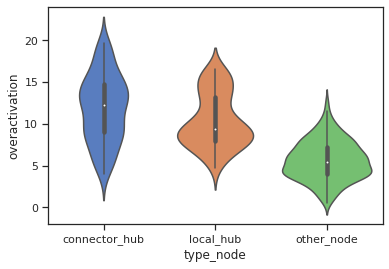

created folder 'figures' at path /home/vincent/Téléchargements/implementation_paper_connectome_2021/
create folder 'png' at path /home/vincent/Téléchargements/implementation_paper_connectome_2021/figures/
saved figure 'Fig4B' at path /home/vincent/Téléchargements/implementation_paper_connectome_2021/figures/png/Fig4B_realistic_connectome_AAL2.png
create folder 'svg' at path /home/vincent/Téléchargements/implementation_paper_connectome_2021/figures/
saved figure 'Fig4B' at path /home/vincent/Téléchargements/implementation_paper_connectome_2021/figures/svg/Fig4B_realistic_connectome_AAL2.svg


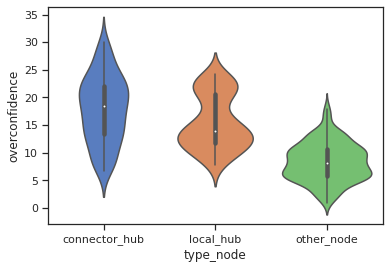

In [4]:
#Fig 4B (overactivation by type of node)

import ptitprince as pt
from utils_save_fig import save_fig
sns.set_style("ticks")
for y in ["overactivation", "overconfidence"]:
#     perso_violin_plot(df_all_simulations, y=y, which=which, strip_move=True)
    sns.violinplot(x='type_node', y=y, data=df_all_simulations, palette='muted', order=['connector_hub', 'local_hub', 'other_node'])
    if y == "overconfidence":
        save_fig("Fig4B", type_graph)
    plt.show()

# Check that the overactivations are determined by the same things for any types of graphs (--> node degree, ...): check that a model learned on  many simulations from a certain graph type is able to predict the overactivation for another graph type.
--> Conclusion: it's impossible to predict the values of overactivations, but the order can be predicted (predicted overactivation and true overactivation highly correlate), which is already great.

Loading the training data...
Data cannot be loaded as they weren't first generated --> run compute_effects_CI_vs_BP.py with the following command: 'python compute_effects_CI_vs_BP.py modular_SW'
20
Starting to load (20 files)...
[====================] 100%Data loaded (removed 0 files out of 20 because networks were frustrated)
Training data loaded
Finished generating and weighting the graph
Finished generating the external messages
Finished running CI
Finished looking for frustration/bistability for CI
Finished running BP
Finished looking for frustration/bistability for BP
Showing M_ext


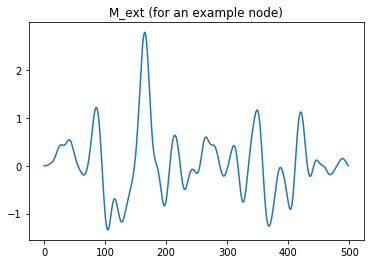

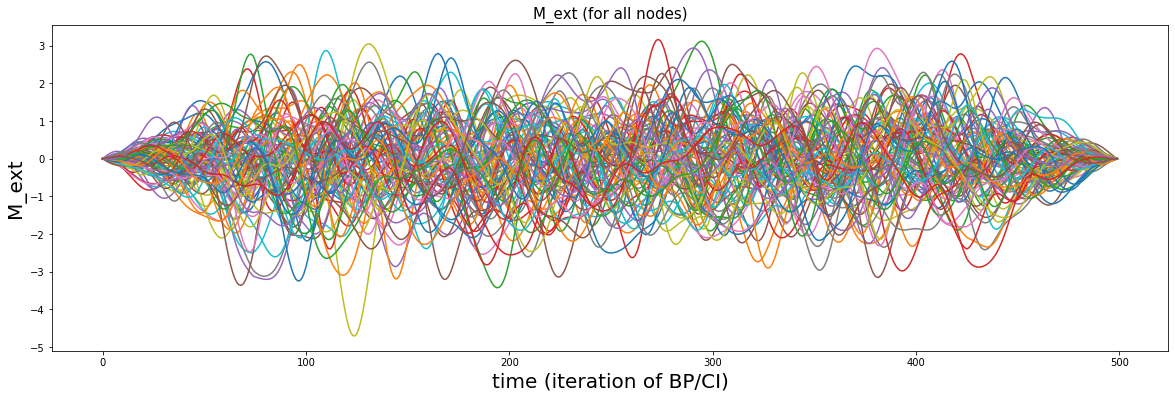

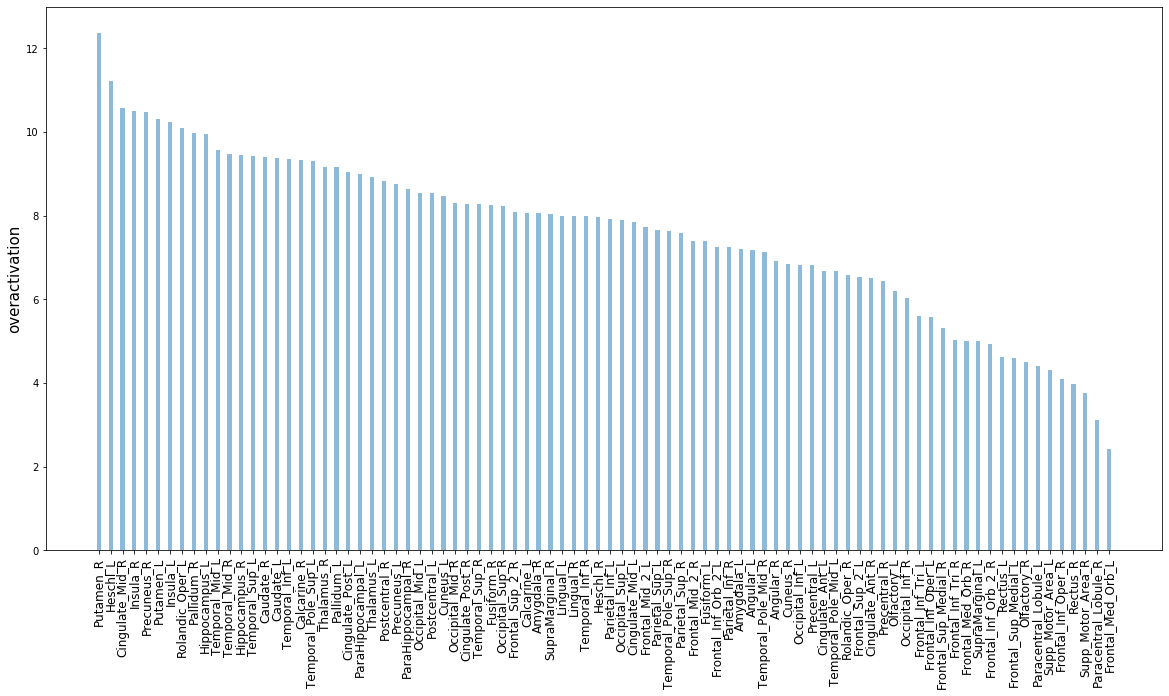

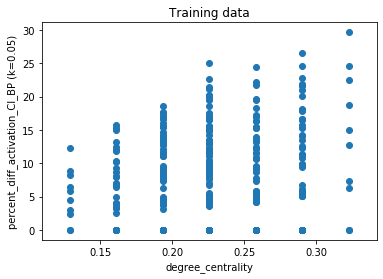

Get the predictions from the linear regression (on all the saved data)
regressed_qty: percent_diff
Regression on the difference in percentage of activations between CI and BP
regressors: ['degree_centrality', 'participation_coefficient_undirected', 'within_community_strength_undirected']
Selecting the nodes for which (alpha_c, alpha_d) = (0.6,0.6)
Regression method: PLS_Regression
x.shape = (64, 3), y.shape = (64,)
n_components = 1, MSE = 11.746827937701687
n_components = 2, MSE = 10.443290354615728
n_components = 3, MSE = 9.643331641482648
return_coef = True, return_reg = True


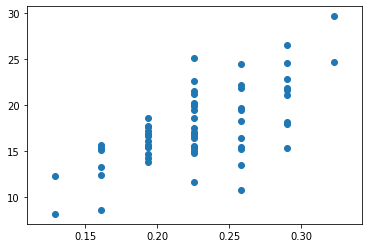

regressors: dict_keys(['degree_centrality', 'participation_coefficient_undirected', 'within_community_strength_undirected'])
3 regressors
x.shape (86, 3)
prediction.shape =  (86, 1)


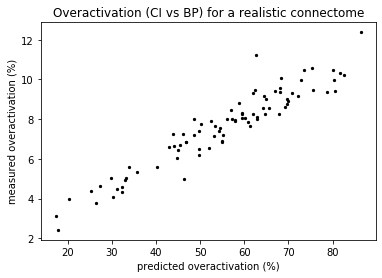

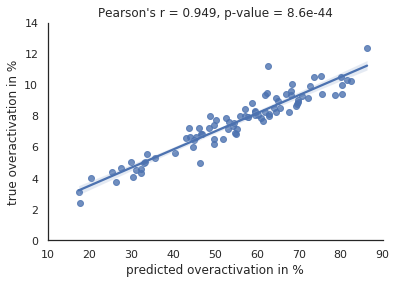

In [6]:
#Fig S2: look at overactivation from one simulation vs overactivation predicted by the linear regression 
#(on other graphs, generated with bct algorithms)

from scipy.stats.stats import pearsonr   
# import pandas as pd
# import numpy as np
# from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats
import scipy.stats as stats
import seaborn as sns
from graph_generator import *
from compute_effects_CI_vs_BP import *
from utils_dict import plot_dict_ordered


##############################  Training data: define  ###################################
#load the training data
from analyze_effects_CI_vs_BP import *
#loading the data only if it's not already loaded (the loading takes time)
try: #looking whether the variable is already defined
    #print("Using already defined training data")
    loading_function_used #so that df_all_alpha_all_files is generated using the function below the 1st time
    df_all_alpha_all_files
except:
    print("Loading the training data...")
    #Training data: parameters for the data loading
    type_M_ext = 'gaussian_process_by_periods' #'gaussian_process_by_periods_not_all_nodes' #'gaussian_process_by_periods' #'poisson_process', 'gaussian_process' #'white_noise'
    path_look_files = path_dir_save #path_nextcloud
    type_graph_train = 'modular_SW'
    remove_cerebellum_and_vermis_train = True
    remove_ofc_train = True
    #load the data
    df_all_alpha_all_files = load_simulated_data(path_look_files, type_M_ext, type_graph_train, k=0.05,
                                                 remove_cerebellum_and_vermis=remove_cerebellum_and_vermis_train,
                                                 remove_ofc=remove_ofc_train
                                                )
    loading_function_used = True
################################################################################################


##############################  Test data: define  ###################################
#(variables required: graph_G, remove_cerebellum_and_vermis, remove_ofc, d_overactivation)
#1. Define graph_G
type_graph_test = 'realistic_connectome_AAL2'
remove_cerebellum_and_vermis_test = True
remove_ofc_test = True
graph_G_test = generate_graph(type_graph=type_graph_test,
                              remove_cerebellum_and_vermis=remove_cerebellum_and_vermis_test,
                              remove_ofc=remove_ofc_test
                             )
# graph_G_test = graph_G #careful: the test data shouldn't be part of the training set
assert 'realistic_connectome' in graph_G_test.type_graph #for the test data
#2. Define d_overactivation
# #Arguments for the simulation
type_graph = 'realistic_connectome_AAL2' #'modular_SW' #'realistic_connectome_HCP'
alpha_c, alpha_d = (0.6, 0.6) #needs to be different from (1, 1), otherwise overactivation = 0
begin = 0 #50
keep_history = True
T_period = 500 #1000 for small graphs, 1000 for big graphs
binarize_realistic_connectome = True
method_weighting = 'bimodal_w'
#Simulate

res = Simulate(type_M_ext='gaussian_process_by_periods_not_all_nodes', 
               alpha_c=alpha_c, alpha_d=alpha_d,
               run_also_BP=True,
               begin=begin, keep_history=keep_history,
               n_periods=1,
               remove_cerebellum_and_vermis=remove_cerebellum_and_vermis_test, remove_ofc=remove_ofc_test,
               binarize_realistic_connectome=binarize_realistic_connectome,
               variance_Mext=100, T_period=T_period, #variance_Mext=0.1
               stimulated_nodes='all', #stimulated_nodes="visual" #stimulates specific nodes (give list or "visual" or "auditory" (in these 2 last cases the stimulated regions are the associated primary cortices))
#                        stimulated_nodes=1, #stimulated_nodes="visual" #stimulates specific nodes (give list or "visual" or "auditory" (in these 2 last cases the stimulated regions are the associated primary cortices))
#                check_frustration_and_bistability=False, predict_frustration_and_bistability=True,
               graph_G=graph_G_test, which_graph_G='structure',
               method_weighting=method_weighting, w_uniform=0.53, #w_uniform=None,
               print_advancement=True
              )
print("Showing M_ext")
show_one_node = True #show M_ext for a single node
plot_M_ext(res.M_ext, show_one_node=show_one_node)
k = np.inf #0.05
method='leaky_belief'
which = 'percent' #'diff'
d_overactivation = res.compute_overactivation(method=method, k=k, begin=begin, which=which)
d_test = d_overactivation #example chosen (we will learn to predict that, and will estimated it with d_predict)
################################################################################################


##############################  Test data: plot  ###################################
# sorted_d = sort_dict_by_value(d_test)
# n_most_overactive_regions = 11
# most_overactive_regions = list(sorted_d.keys())[:n_most_overactive_regions]
# print("{} most overactive regions: {}".format(n_most_overactive_regions, most_overactive_regions))
plot_dict_ordered(d_test, ylabel="overactivation") #plot the regions from the most overactive to the least overactive
################################################################################################


##############################  Training data: plot  ###################################
arr = np.array([df_all_alpha_all_files['degree_centrality'],
                df_all_alpha_all_files['percent_diff_activation_CI_BP (k=0.05)']
               ]).T
plt.scatter(arr[:,0], arr[:,1])
plt.xlabel('degree_centrality')
plt.ylabel('percent_diff_activation_CI_BP (k=0.05)')
plt.title('Training data')
plt.show()
################################################################################################


############################################################################################
# Prediction from the regression
############################################################################################


print("Get the predictions from the linear regression (on all the saved data)")

    
#choose the regression method
method = 'PLS_Regression'

#best regressors (each is able to predict well alone without other regressors): degree_centrality, closeness_centrality_undirected, harmonic_centrality_undirected, local_reaching_centrality_undirected
list_regressors = [
    'degree_centrality',
#     'neighbors_length_2',
#     'neighbors_length_3',
#     'neighbors_length_4',
# #         'katz_centrality_undirected',
#     'closeness_centrality_undirected',
# #         'betweenness_centrality_undirected',
# #         'load_centrality_undirected',
#     'harmonic_centrality_undirected',
#     'local_reaching_centrality_undirected',
    'participation_coefficient_undirected',
#     'clustering_undirected',
#     'square_clustering_undirected',
#     'average_neighbor_degree'
    'within_community_strength_undirected'
] #case where direction is not important (alpha_c=alpha_d)

#select the regressed variable
regressed_qty = 'percent_diff'
print("regressed_qty:", regressed_qty)
if regressed_qty == 'diff':
    print("Regression on the difference of activations between CI and BP")
    activation_columns = [col_name for col_name in list(df_all_alpha_all_files.columns) if (('diff_activation_CI_BP' in col_name) and ('percent_diff_activation_CI_BP' not in col_name))]
elif regressed_qty == 'percent_diff':
    print("Regression on the difference in percentage of activations between CI and BP")
    activation_columns = [col_name for col_name in list(df_all_alpha_all_files.columns) if 'percent_diff_activation_CI_BP' in col_name]
else:
    print()
    sys.exit()
# print(list(df_all_alpha_all_files.columns))
# print(activation_columns)
print("regressors: {}".format(list_regressors))
if len(activation_columns) == 1:
    regressed_variable = activation_columns[0]
else:
    print("select the value of k")
    sys.exit()


#predicting the most active nodes for alpha_c = alpha_d = 0.6 in the realistic connectome

(alpha_c, alpha_d) = (0.6, 0.6)
print("Selecting the nodes for which (alpha_c, alpha_d) = ({},{})".format(alpha_c, alpha_d))
df_select = df_all_alpha_all_files[(df_all_alpha_all_files['alpha_c'] == alpha_c) &
                                   (df_all_alpha_all_files['alpha_d'] == alpha_d)]
_, reg = do_reg(df_select, list_regressors, regressed_variable=regressed_variable, check_reg=False, return_coef=True, return_reg=True, method=method)

arr = np.array([df_select['degree_centrality'],
                df_select['percent_diff_activation_CI_BP (k=0.05)']
               ]).T
plt.scatter(arr[:,0], arr[:,1])
plt.show()


def predict_most_active_nodes(reg, graph_G, list_regressors): 
    """
    #previsouly calledpredict_new_data(reg, G)
    """
    #compute graph measures
    from utils_graph_measures import all_fun_measures
    all_measures_graph = {}
    for measure_name, fun_measure in all_fun_measures.items():
        if measure_name in list_regressors: #check that it is one of the selected regressors
            all_measures_graph[measure_name] = fun_measure(graph_G)
            assert list(all_measures_graph[measure_name].keys()) == list(graph_G.nodes())
            all_measures_graph[measure_name] = list(all_measures_graph[measure_name].values())
    # print(all_measures_graph)
    print("regressors: {}".format(all_measures_graph.keys()))
    print("{} regressors".format(len(all_measures_graph.keys())))

    list_measure_names = list(all_measures_graph.keys())

    #plot graph measures
#     for measure_name, measure_val in all_measures_graph.items():
#         plt.plot(measure_val)
#         plt.title(measure_name)
#         plt.show()    

    x = np.array(list(all_measures_graph.values())).T #TODO (maybe): center and normalize the values by measure_name?
#     x = (scale(x)) #normalization #I'm not sure that I should do that...

    print("x.shape", x.shape)
    y_pred = reg.predict(x)  # make predictions
    return y_pred



#predict the value of the activation for the test data graph_G_test
prediction = predict_most_active_nodes(reg, graph_G_test, list_regressors)
print("prediction.shape = ", prediction.shape)
# plt.plot(prediction)
# plt.xlabel("node")
# plt.ylabel("predicted activation (from graph only)")
# plt.show()

#make dictionnary (=concatenate the names of regions with the prediction of the activation)
d_predict = dict(zip(list(graph_G_test.nodes), prediction.flatten())) 

#print the regions, from the most active to the least active
# sorted_d_predict = dict(sorted(d_predict.items(), key=lambda x: x[1], reverse=True))
# print("sorted_d_predict:\n", sorted_d_predict)

#print the n most active regions
# n_most_active_regions = 11
# most_active_regions = list(sorted_d_predict.keys())[:n_most_active_regions]
# print("{} most_active_regions (prediction): {}".format(len(most_active_regions), most_active_regions))


#Plot the predicted overactivation vs the true overactivation (=test set)
# assert list(d_test.keys()) == list(d_predict.keys())
assert set(list(d_test.keys())) <= set(list(d_predict.keys())) #set inclusion (as d doesn't have unconnected nodes)
x = list({key: d_predict[key] for key in d_test.keys()}.values())
y = list(d_test.values())
plt.scatter(x, y, s=5, color='black')
plt.title('Overactivation (CI vs BP) for a realistic connectome')
if regressed_qty == 'percent_diff':
    plt.xlabel('predicted overactivation (%)')# (from graph only)')
    plt.ylabel('measured overactivation (%)')
else:
    plt.xlabel('predicted overactivation')# (from graph only)')
    plt.ylabel('measured overactivation')
# x_lin = np.linspace(np.min([x,y]), np.max([x,y]), 2)
# plt.plot(x_lin, x_lin, color='black', linestyle='--')
plt.show()

#Same as above, with the regression line (see seaborn functions: regplot and lmplot) and the 95% confidence interval (sometimes invisible because too close to the regression line)
sns.set(color_codes=True)
sns.set(style="white")
r,pval = stats.pearsonr(x, y)
# print("r (corr_coef) = {}".format(r))
# print("r2 = {}".format(r**2))
# print("pval = {}".format(pval))
ax = sns.regplot(x, y)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('Overactivation (CI vs BP) for a realistic connectome')
plt.title('Pearson\'s r = {}, p-value = {:0.1e}'.format(np.round(r,3), pval))
if regressed_qty == 'percent_diff':
    plt.xlabel('predicted overactivation in %') #(from graph only)
    plt.ylabel('true overactivation in %')
else:
    plt.xlabel('predicted overactivation') #(from graph only)
    plt.ylabel('true overactivation')
#show xticks and yticks = (0,0)
locs, labels = plt.xticks()
plt.xticks(locs,[int(el) for el in locs])
locs, labels = plt.yticks()
plt.yticks(locs,[int(el) for el in locs])
save_fig("FigS2", type_graph)
plt.show()

# print("Statistics obtained with another method (--> we get the same results)")
# import statsmodels.api as sm
# x2 = sm.add_constant(x)
# est = sm.OLS(y, x2)
# est2 = est.fit()
# # print(est2.summary())
# print("r_squared = {}".format(est2.rsquared))
# print("p-value = {}".format(est2.pvalues[-1]))
# print("p-values:")
# print(est2.summary2().tables[1]['P>|t|'])

############################################################################################

# Distribution of activities for CI vs BP
Using code from analysis_effects_CI_vs_BP.py (see also the .ipynb file)

In [1]:
from analyze_effects_CI_vs_BP import *

#load the data
type_M_ext = 'gaussian_process_by_periods' #'gaussian_process', 'poisson_process'
list_k = [0, 0.01, 0.05, 0.1, 0.2, 0.5, np.inf] #np.inf is only for the overconfidence plot
# path_look_files = path_nextcloud
path_look_files = path_dir_save
type_graph_loaded = 'modular_SW'
remove_cerebellum_and_vermis_loaded = False
remove_ofc_loaded = True

df_all_alpha_all_files = load_simulated_data(path_look_files, type_M_ext, type_graph_loaded, k=list_k,
                                             remove_cerebellum_and_vermis=remove_cerebellum_and_vermis_loaded,
                                             remove_ofc=remove_ofc_loaded
                                            )

/home/vincent/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Starting to load (20 files)...
[====================] 100%Data loaded (removed 0 files out of 20 because networks were frustrated)


percent_diff_activation_CI_BP (k=0)
both


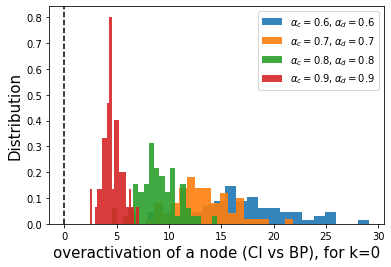

percent_diff_activation_CI_BP (k=0.01)
both


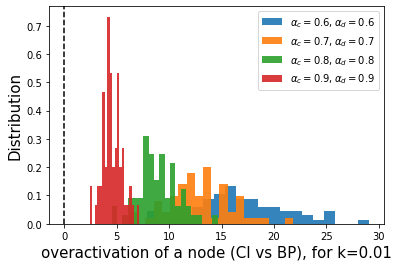

percent_diff_activation_CI_BP (k=0.05)
both


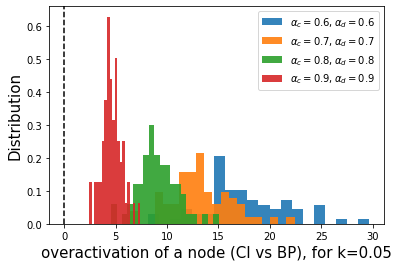

percent_diff_activation_CI_BP (k=0.1)
both


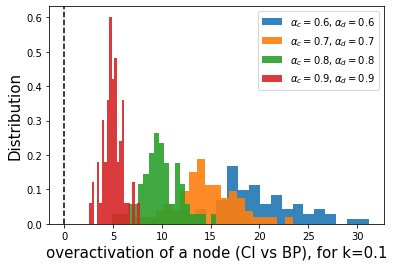

percent_diff_activation_CI_BP (k=0.2)
both


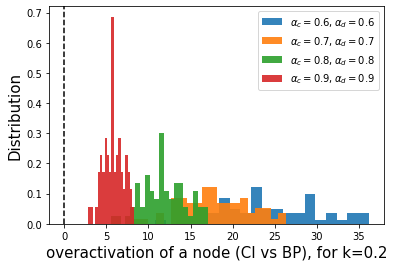

percent_diff_activation_CI_BP (k=0.5)
both


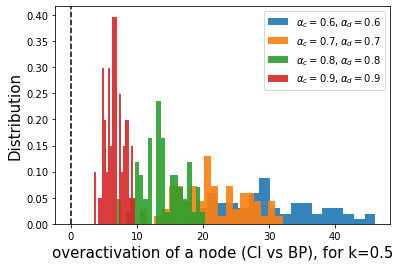

percent_diff_activation_CI_BP (k=inf)
both


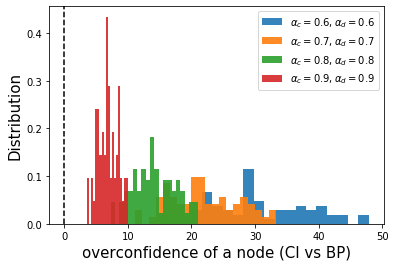

In [2]:
lists_all = {
#     'asc': [[0.7,0.8,0.9,1], [1]],
#     'des': [[1], [0.7,0.8,0.9,1]],
    'both': [[0.6, 0.7, 0.8, 0.9, 1],[0.6, 0.7, 0.8, 0.9, 1]]
}

# activation_columns = [col_name for col_name in list(df_all_alpha_all_files.columns) if 'sum_sq_upd_CI_min_BP' in col_name]
# print(activation_columns)

for k in list_k:

    #select the regressed variable
    regressed_variable = 'percent_diff_activation_CI_BP (k={})'.format(k) #'diff_activation_CI_BP'
    print(regressed_variable)
    
    coef_all_alpha_all = []
    for key, lists_alpha in lists_all.items():
        print(key)
        list_alpha_c, list_alpha_d = lists_alpha

        if key != 'both':
            list_alphac_alphad = itertools.product(list_alpha_c, list_alpha_d)
        else: #key == 'both'
            list_alphac_alphad = [(list_alpha_c[i], list_alpha_d[i]) for i in range(len(list_alpha_c))]

        for (alpha_c, alpha_d) in list_alphac_alphad:
            if (alpha_c==1 and alpha_d==1):
                continue
            df_select = df_all_alpha_all_files[(df_all_alpha_all_files['alpha_c'] == alpha_c) &
                                               (df_all_alpha_all_files['alpha_d'] == alpha_d)]
            y = df_select[[regressed_variable]].values.flatten()
            plt.hist(y, label=r"$\alpha_c = {}, \alpha_d = {}$".format(alpha_c, alpha_d), bins=20, alpha=0.9, density=True)
        plt.legend()
#         if k != np.inf:
#             plt.xlim(-35,100)
        plt.axvline(x=0, linestyle='--', color='black')
        if k != np.inf:
            plt.xlabel('overactivation of a node (CI vs BP), for k={}'.format(k), size=15)
        else: #k = np.inf
            plt.xlabel('overconfidence of a node (CI vs BP)', size=15)
        plt.ylabel('Distribution', size=15)
        plt.show()

Sometimes we get only positive overactivations, sometimes we get both negative and positive overactivations